# WELCOME TO MY CAPSTONE PROJECT : PREDICTING UNDER FIVE MORTALITY IN HAITI

                                         (A Machine Learning & Deep Learning Approach)

In [99]:
# import needful libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scistat
import sklearn as sk



# Partition data into training and testing set
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn import svm

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import classification_report

from sklearn.metrics import plot_roc_curve

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import OneHotEncoder



# Import one hot encoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score





from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import wilcoxon






In [100]:

# We have created a module able to take the Stata folder, 
# to detect the extension of the .DTA file of the database, 
# to go to the .DO dictionary file, 
# to take the labels of the variables and modalities, 
# and to replace them respectively in the STATA database.



class ReadStataFile:
    def __init__(self,folder_name):
        self.folder_name= folder_name
        self.__load_columns__()

    def __load_columns__(self):
      
        file_name =self.folder_name[0:-2]+"FL"
        obj = open(f"./{self.folder_name}/{file_name}.DO")
        lines = obj.readlines()
        labels = {}
        for line in lines[2:]:
            if line != "#delimit ;" and len(line.strip()) >0 :
                my_split = line.split('\"')
                my_var = my_split[0].replace("label variable","").strip()
                my_label = my_split[1].strip()
                labels[my_var]=my_label
            
            else:
                break;
        self.variables = labels.keys()
        self.labels = labels.values()
        self.col_dict =labels
        obj.close()
    
    def get_col_modality(self,variable_name):
        # #delimit cr
      
        folder_name = "HTBR71DT"
        file_name =self.folder_name[0:-2]+"FL"
        obj = open(f"./{self.folder_name}/{file_name}.DO")
        lines = obj.readlines()
        flag_delimiter = 0
        flag_variable_found = 0
        labels ={}
        for line in lines[2:]:
            #print(line)
            if line.lower().strip().find("delimit") >0:
                flag_delimiter = 1
                #print("delimiter found !!!")
            elif line.lower().find(variable_name.lower()) >0 and flag_delimiter == 1:
                flag_variable_found = 1
                #print("variable found !!!")
            elif flag_variable_found == 1 and flag_delimiter == 1 and  line.lower().find(variable_name.lower()) ==-1 and len(line.strip()) >0 and line.strip() != ";" and  len(line.split('\"')) >1   :
                my_split = line.split('\"')    
                my_var_string = my_split[0].strip()
                if self.is_number(my_var_string):
                    my_var = float(my_var_string)
                else:
                    my_var = my_var_string
                my_label = my_split[1].strip()
                labels[my_var]=my_label
                
            
            elif flag_variable_found == 1 and flag_delimiter == 1 and line.strip() == ";" :
                #print("variable not found !!!")
                break;
        obj.close()
        return labels 

    def get_col_label(self,variable_name):
        return self.col_dict.get(variable_name.lower())

    def to_dataframe(self,use_modality=False):
        import pandas as pd
        file_name =self.folder_name[0:-2]+"FL"
        df = pd.read_stata(f"./{self.folder_name}/{file_name}.DTA",convert_categoricals=False)
        if  use_modality:
          for col in self.variables:
              my_dict = self.get_col_modality(col)
              df[col].replace(my_dict,inplace=True)
        df.rename(columns=self.col_dict,inplace=True)
        return df

    def is_number(self,string):
        try:
            float(string)
            return True
        except ValueError:
            return False


In [101]:
children_under_five = ReadStataFile("HTKR71DT")

data = children_under_five.to_dataframe(use_modality=True)

In [102]:
data.head()

,Case Identification,Index to Birth History,Country code and phase,Cluster number,Household number,Respondent's line number,Ultimate area unit,Women's individual sample weight (6 decimals),Month of interview,Year of interview,Date of interview (CMC),Date of interview Century Day Code (CDC),Respondent's month of birth,Respondent's year of birth,Date of birth (CMC),Respondent's current age,Age in 5-year groups,Completeness of age information,Result of individual interview,Day of interview,CMC start of calendar,Row of month of interview,Length of calendar,Number of calendar columns,Ever-married sample,Primary sampling unit,Sample strata for sampling errors,Stratification used in sample design,Region,Type of place of residence,NA - De facto place of residence,Number of visits,Interviewer identification,NA - Keyer identification,Field supervisor,NA - Field editor,NA - Office editor,Line number of husband,Cluster altitude in meters,Household selected for hemoglobin,Selected for Domestic Violence module,Language of questionnaire,Language of interview,Native language of respondent,Translator used,Region_,Type of place of residence2,NA - Childhood place of residence,Years lived in place of residence,Type of place of previous residence,Region of previous residence,Highest educational level,Highest year of education,Source of drinking water,Time to get to water source,Type of toilet facility,Household has: electricity,Household has: radio,Household has: television,Household has: refrigerator,Household has: bicycle,Household has: motorcycle/scooter,Household has: car/truck,Main floor material,Main wall material,Main roof material,Religion,NA - Ethnicity,Education in single years,NA - De facto place of residence,Usual resident or visitor,Number of household members (listed),Number of children 5 and under in household (de jure),Number of eligible women in household (de facto),De jure region of residence,De jure type of place of residence,NA - De jure place of residence,Educational attainment,Relationship to household head,Sex of household head,Age of household head,Household has: telephone (land-line),All woman factor - total,All woman factor - urban/rural,All woman factor - regional,All woman factor - educational,All woman factor - wealth index,Literacy,NA - Ever participated in a literacy program outside of primary,Frequency of reading newspaper or magazine,Frequency of listening to radio,Frequency of watching television,Toilet facilities shared with other households,Type of cooking fuel,Result of salt test for iodine,Number of trips in last 12 months,Away for more than one month in last 12 months,Owns a mobile telephone,Use mobile telephone for financial transactions,Has an account in a bank or other financial institution,Use of internet,Frequency of using internet last month,Wealth index combined,Wealth index factor score combined (5 decimals),Wealth index for urban/rural,Wealth index factor score for urban/rural (5 decimals),Type of mosquito bed net(s) slept under last night,Total children ever born,Sons at home,Daughters at home,Sons elsewhere,Daughters elsewhere,Sons who have died,Daughters who have died,Births in last five years,Births in past year,Births in month of interview,Date of first birth (CMC),Age of respondent at 1st birth,Currently pregnant,Duration of current pregnancy,Time since last menstrual period,Menstruated in last six weeks,Knowledge of ovulatory cycle,Number of living children,Living children + current pregnancy,Living children + current pregnancy (grouped),Marriage to first birth interval (months),Last birth to interview (months),Completeness of current pregnancy information,Entries in birth history,Current pregnancy wanted,Time since last period (comp) (months),Flag for last period,Ever had a terminated pregnancy,Month pregnancy ended,Year pregnancy ended,CMC pregnancy ended,Completeness of last termination information,Months when pregnancy ended,Other such pregnancies,Index last child prior to maternity-health

In [103]:
print(data.shape)

(6530, 1216)


#### We have 1216 columns. We will choose the determinants that could best explain Under Five Mortality

cols_selected:



        "Year of interview", 
        "Region", 
        "Respondent's year of birth",
        "Age in 5-year groups", 
        "Type of place of residence", 
        "Highest educational level", 
        "Relationship to household head", 
        "Educational attainment", 
        "Number of children 5 and under in household (de jure)", 
        "Date of first birth (CMC)", 
        "Age of respondent at 1st birth", 
        "Number of living children", 
        "Size of child at birth", 
        "Women's age in years (from household questionnaire)", 
        "Under age 18 (from household questionnaire)", 
        "Marital status", 
        "Current marital status", 
        "Type of toilet facility", "Place of delivery", 
        "Delivery by caesarean section", 
        "Wealth index combined", 
        "Child's age in months", 
        "Wealth index factor score combined (5 decimals)", 
        "Wealth index for urban/rural", 
        "Body Mass Index", 
        "Births in last five years"
        "Baby postnatal check within 2 months", 
        "Sex of child", 
        "Age of respondent at 1st birth", 
        "Birth order number", 
        "Women's age in years (from household questionnaire)", 
        "Time to get to water source",
        "Source of drinking water", 
        "Wanted last child", 
        "Current contraceptive method", 
        "Place of delivery", 
        "Number of antenatal visits during pregnancy", 
        "Marital status", 
        "When child put to breast", 
        "Type of place of residence", 
        "When child put to breast", 
        "Wealth index factor score for urban/rural (5 decimals)" , 
        "Total children ever born", 
        "Births in last five years", 
        "Births in past year", 
        "Births in month of interview", 
        "Date of first birth (CMC)", 
        "Age of respondent at 1st birth", 
        "Currently pregnant", 
        "Number of living children", 
        "Marriage to first birth interval (months)", 
        "Births in last three years", 
        "Current marital status", 
        "Currently/formerly/never in union", 
        "Currently residing with husband/partner", 
        "Birth column number", 
        "Birth order number", 
        "Year of birth", 
        "Date of birth (CMC)", 
        "Sex of child", 
        "Child is alive", 
        "Age at death", 
        "Age at death (months, imputed)", 
        "Current age of child", 
        "Child lives with whom",  
        "Preceding birth interval (months)", 
        "Child's line number in household", 
        "Current age of child in months (months since birth for dead children)", 
        "Size of child at birth", 
        "Birth weight in kilograms (3 decimals)"]

In [104]:
# we select the colomns

cols_selected = ["Year of interview", "Region", "Births in last five years", "Respondent's year of birth","Age in 5-year groups", "Type of place of residence", "Highest educational level", "Relationship to household head", "Educational attainment", "Number of children 5 and under in household (de jure)", "Date of first birth (CMC)", "Age of respondent at 1st birth", "Number of living children", "Size of child at birth", "Women's age in years (from household questionnaire)", "Under age 18 (from household questionnaire)", "Marital status", "Current marital status", "Type of toilet facility", "Place of delivery", "Delivery by caesarean section", "Wealth index combined", "Child's age in months", "Wealth index factor score combined (5 decimals)", "Wealth index for urban/rural", "Body Mass Index", "Baby postnatal check within 2 months", "Sex of child", "Age of respondent at 1st birth", "Birth order number", "Women's age in years (from household questionnaire)", "Time to get to water source","Source of drinking water", "Wanted last child", "Current contraceptive method", "Place of delivery", "Number of antenatal visits during pregnancy", "Marital status", "When child put to breast", "Type of place of residence", "When child put to breast", "Wealth index factor score for urban/rural (5 decimals)" , "Total children ever born", "Births in last five years", "Births in past year", "Births in month of interview", "Date of first birth (CMC)", "Age of respondent at 1st birth", "Currently pregnant", "Number of living children", "Marriage to first birth interval (months)", "Births in last three years", "Current marital status", "Currently/formerly/never in union", "Currently residing with husband/partner", "Birth column number", "Birth order number", "Year of birth", "Date of birth (CMC)", "Sex of child", "Child is alive", "Age at death", "Age at death (months, imputed)", "Current age of child", "Child lives with whom",  "Preceding birth interval (months)", "Child's line number in household", "Current age of child in months (months since birth for dead children)", "Size of child at birth", "Birth weight in kilograms (3 decimals)", "Number of household members (listed)"]
data_selected = data[set(cols_selected)]

In [105]:
# We go from 1216 variables to only 58
print(data_selected.shape)

(6530, 58)


## Data Cleaning


### Among all columns with the modality "Not a dejure resident", 152 same rows observe this modality. These 152 observations should be eliminated for lack of credibility.

In [106]:
# drop rows that contain specific 'value': "Don't know" & "Not a dejure resident" in 'column_name':  "Time to get to water source"

data_selected = data_selected[(data_selected["Time to get to water source"]!= "Not a dejure resident") & (data_selected["Time to get to water source"]!= "Don't know")]

In [107]:
print(data_selected.shape)

(6376, 58)


In [108]:
data_selected["Time to get to water source"] = data_selected["Time to get to water source"].replace(["On premises"], 1)

In [109]:
# drop rows that contain nan & 'Flagged cases' in 'column_name':  "Body Mass Index"


data_selected = data_selected[~(data_selected["Body Mass Index"].isna())&(data_selected["Body Mass Index"]!= 'Flagged cases')]

In [110]:
print(data_selected.shape)

(4253, 58)


### We will group the modalities of the variable "Age of respondent at 1st birth" in 2 groups of modality: < 20 years, > 20 years for convenience

In [111]:
data_selected["Age of respondent at 1st birth"].value_counts()

19    487
18    470
20    442
17    435
21    351
22    338
16    308
23    256
24    189
15    160
25    144
26    124
28    116
27    108
29     63
14     48
30     44
31     41
33     26
32     24
34     22
13     19
35      8
36      7
38      7
12      6
11      3
37      3
40      1
43      1
41      1
39      1
Name: Age of respondent at 1st birth, dtype: int64

In [112]:
 # The function that groups in 2 modalities

def age_at_birth(x):
    return '< 20 years' if x < 20 else '>= 20 years'


data_selected["Age of respondent at 1st birth"] = data_selected["Age of respondent at 1st birth"].apply(age_at_birth)

In [113]:
data_selected["Age of respondent at 1st birth"].unique()

array(['>= 20 years', '< 20 years'], dtype=object)

### We will group the modalities of the variable "Marital status" in 2 groups of modality: 'Women currently en union' & 'Women currently alone' for convenience

In [114]:
data_selected["Marital status"].value_counts()

Currently placï¿½e    2099
Currently married     1086
Currently vivavek      512
Never married          259
Separated              223
Widowed                 44
Living together         26
Divorced                 4
Name: Marital status, dtype: int64

In [115]:
#  The function that groups in 2 modalities

def marital(x):
    return 'Women currently en union' if x in ["Currently married", "Currently plac�e", "Currently vivavek", "Living together"] else 'Women currently alone'

data_selected["Marital status"] = data_selected["Marital status"].apply(marital)

In [116]:
data_selected["Marital status"].unique()

array(['Women currently en union', 'Women currently alone'], dtype=object)

### We will group the modalities of the variable "Number of antenatal visits during pregnancy" in 3 groups of modality: "No antenatal visits", "1-4 visits", "5+ visits" for convenience

In [117]:
data_selected["Number of antenatal visits during pregnancy"].value_counts()

6.0                    537
5.0                    445
3.0                    416
4.0                    385
7.0                    382
No antenatal visits    288
8.0                    248
2.0                    239
1.0                    147
9.0                    105
10.0                    31
12.0                    14
15.0                     8
14.0                     4
16.0                     3
18.0                     3
17.0                     2
11.0                     2
20.0                     2
13.0                     1
Don't know               1
Name: Number of antenatal visits during pregnancy, dtype: int64

In [118]:
#  The function that groups in 3 modalities

def antenatal(x):
    if x in ["No antenatal visits", "Don't know"]:
        return "No antenatal visits"
    elif x >= 1 and x<= 4:
        return "1-4 visits"
    else:
        return "5+ visits"

data_selected["Number of antenatal visits during pregnancy"] = data_selected["Number of antenatal visits during pregnancy"].apply(antenatal)

In [119]:
data_selected["Number of antenatal visits during pregnancy"].unique()

array(['5+ visits', '1-4 visits', 'No antenatal visits'], dtype=object)

### We will group the modalities of the variable "Baby postnatal check within 2 months" in 2 groups of modality: "Yes", "No" for convenience

In [120]:
data_selected["Baby postnatal check within 2 months"].value_counts()

Yes           2218
No            1026
Don't know       5
Name: Baby postnatal check within 2 months, dtype: int64

In [121]:
#  The function that groups in 2 modalities

def postnatal(x):
    return 'No' if x in ["Don't know", "No"] else 'Yes'

data_selected["Baby postnatal check within 2 months"] = data_selected["Baby postnatal check within 2 months"].apply(postnatal)

In [122]:
data_selected["Baby postnatal check within 2 months"].unique()

array(['Yes', 'No'], dtype=object)

### We will group the modalities of the variable "Time to get to water source" in 4 groups of modality: "On premises", "1-30", "30-60", "60+" for convenience

In [123]:
data_selected["Time to get to water source"].value_counts()

10     712
30     527
15     507
1      487
5      433
60     407
20     342
120    180
45     124
25      97
40      94
90      81
180     67
50      31
35      28
70      14
3       13
240     12
4       10
8        9
7        9
6        8
16       7
80       7
150      7
300      6
160      6
2        6
75       5
55       4
12       4
360      2
130      2
65       2
100      1
110      1
140      1
Name: Time to get to water source, dtype: int64

In [124]:
data_selected["Time to get to water source (categorical)"] = np.nan

def time_categorical(x):
    if x == 1:
        return "On premises"
    elif x > 1 and x <= 30:
        return "1-30"
    elif x > 30 and x <= 60:
        return "30-60"
    else:
        return "60+"

data_selected["Time to get to water source (categorical)"] = data_selected["Time to get to water source"].apply(time_categorical)

In [125]:
data_selected["Time to get to water source (categorical)"].unique()

array(['1-30', 'On premises', '30-60', '60+'], dtype=object)

### For convenience we will group the modalities of the variable "Highest educational level" into 3 modality groups: "No education", "Primary", "Secondary or higher"

In [126]:
data_selected["Highest educational level"].value_counts()

Primary         1744
Secondary       1497
No education     890
Higher           122
Name: Highest educational level, dtype: int64

In [127]:
#  The function that groups in 3 modalities

def education(x):
    if x in "No education":
        return "No education"
    elif x in "Primary":
        return "Primary"
    else:
        return "Secondary or higher"

data_selected["Highest educational level"] = data_selected["Highest educational level"].apply(education)   

In [128]:
data_selected["Highest educational level"].unique()

array(['Primary', 'Secondary or higher', 'No education'], dtype=object)

### For convenience we will group the modalities of the variable "Preceding birth interval (months)" into 3 modality groups: < 2 years, 2-4 years, > 4 years

In [129]:
data_selected["Preceding birth interval (months)"].value_counts()

24.0     86
28.0     80
26.0     75
22.0     74
23.0     72
         ..
180.0     1
216.0     1
154.0     1
213.0     1
223.0     1
Name: Preceding birth interval (months), Length: 167, dtype: int64

In [130]:
#  The function that groups in 3 modalities

def birth_interval(x):
    if x < 24.0:
        return "< 2 years"
    elif x > 48.0:
        return "> 4 years"
    else:
        return "2-4 years"

data_selected["Preceding birth interval (months)"] = data_selected["Preceding birth interval (months)"].apply(birth_interval)

In [131]:
data_selected["Preceding birth interval (months)"].unique()

array(['< 2 years', '2-4 years', '> 4 years'], dtype=object)

### We will take two variables: "Place of delivery" & "Delivery by caesarean section" to form only one variable: "Place and Mode of delivery services"


In [132]:
data_selected["Place of delivery"].value_counts()

Respondent's home                             2474
Government hospital                            973
Government health center                       263
Other home                                     181
Private hospital/clinic                        128
Mix Hospital/clinic                             95
Other                                           49
Private health center                           28
Government maternity and delivery hospital      22
Mix Health center                               21
Private maternity and delivery hospital         14
Mix-maternity and delivery hospital              5
Name: Place of delivery, dtype: int64

In [133]:
 # The function that groups in 2 modalities

def PlaceDelivery(x):
    return 'Home' if x in ["Respondent's home", "Other home"] else 'Fair access to care'

data_selected["Place of delivery"] = data_selected["Place of delivery"].apply(PlaceDelivery)

In [134]:
data_selected["Place of delivery"] = data_selected["Place of delivery"].str.capitalize()
data_selected["Place of delivery"].unique()

array(['Home', 'Fair access to care'], dtype=object)

In [135]:

data_selected["Delivery by caesarean section"].value_counts()

No     4021
Yes     216
Name: Delivery by caesarean section, dtype: int64

In [136]:
data_selected['Place and mode of delivery services'] =np.nan

home_filter = data_selected["Place of delivery"] == 'Home'
caesarean_section_yes = data_selected["Delivery by caesarean section"] == 'Yes'

data_selected.loc[home_filter,'Place and mode of delivery services'] = 'Home'
data_selected.loc[(~home_filter)& (caesarean_section_yes),'Place and mode of delivery services'] = 'Fac with CS delivery'
data_selected.loc[(~home_filter)& (~caesarean_section_yes),'Place and mode of delivery services'] = 'Fac without CS delivery'

In [137]:
data_selected['Place and mode of delivery services'].unique()

array(['Home', 'Fac without CS delivery', 'Fac with CS delivery'],
      dtype=object)

### The variable "Birth order number" has 15 modalities. We will group them into 2 groups of categories: "1st or 2nd" & "3rd or higher"

In [138]:
data_selected['Birth order number'].value_counts()

1     1252
2      931
3      636
4      458
5      320
6      225
7      160
8      122
9       72
10      39
11      20
12      10
13       6
14       2
Name: Birth order number, dtype: int64

In [139]:
 # The function that groups in 2 modalities

def birthOrder(x):
    return '1st_or_ 2nd' if x == 1 or x ==2 else '3rd higher'

data_selected['Birth order number'] = data_selected['Birth order number'].apply(birthOrder)

In [140]:
data_selected['Birth order number'].unique()

array(['3rd higher', '1st_or_ 2nd'], dtype=object)

### The variable "When child put to breast" has 34 modalities. In order of importance: 
    Immediately,   
    Hours: 1,   
    Within the first hour,   
    102.0,   
    Days: 1,   etc.  
    We will group them into 2 groups of modalities which are:  'Within an hour of birth'   &   'Greater than on hour of birth'

In [141]:
data_selected['When child put to breast'].value_counts()

Immediately          1465
Hours: 1              667
Within first hour     590
102.0                 441
Days: 1               233
103.0                 195
202.0                  96
104.0                  96
203.0                  92
105.0                  46
106.0                  42
204.0                  19
112.0                  18
108.0                  14
107.0                  10
205.0                  10
215.0                   7
208.0                   7
207.0                   6
110.0                   5
113.0                   5
223.0                   3
111.0                   3
116.0                   3
109.0                   3
213.0                   2
214.0                   2
222.0                   2
115.0                   2
209.0                   2
206.0                   1
210.0                   1
Name: When child put to breast, dtype: int64

In [142]:
#  The function that groups in 2 modalities

def breastfed(x):
    return 'Within an hour of birth' if x in ["Immediately", "Hours: 1", "Within first hour"] else 'Greater than on hour of birth'

data_selected['When child put to breast'] = data_selected['When child put to breast'].apply(breastfed)

In [143]:
data_selected['When child put to breast'].unique()

array(['Within an hour of birth', 'Greater than on hour of birth'],
      dtype=object)

### For the sake of convenience, we will group the modalities of the variable "Source of drinking water" into 2 groups of modalities: Unimproved & Improved

As defined by the Joint WHO & UNICEF Monitoring Programme (JMP), an unimproved drinking-water source is one that by the nature of its construction does not adequately protect the source from outside contamination, in particular with faecal matter. Unimproved drinking-water sources include: Unprotected (dug) well; unprotected spring, cart with small tank or drum; tanker truck-provided water, surface water (river, dam, lake, pond, stream, canal, irrigation channel); bottled water (because of potential limits on the quantity of water available to a household through this source, not the quality). 



        Cf.: 
        https://sswm.info/content/unimproved-drinking-water-sources#:~:text=As%20defined%20by%20the%20Joint%20WHO%20%26%20UNICEF,from%20outside%20contamination%2C%20in%20particular%20with%20faecal%20matter.



As defined by the Joint WHO & UNICEF Monitoring Programme (JMP), an improved drinking-water source is one that by the nature of its construction adequately protects the source from outside contamination, in particular with faecal matter. These include: Piped water connection into dwelling, yard or plot; Public tap or standpipe; tube well or borehole; protected dug well; protected spring; rainwater collection.


        Cf.:
        https://sswm.info/content/improved-drinking-water-sources

In [144]:
data_selected["Source of drinking water"].value_counts()

Unprotected spring                                      1191
Water selling kiosk/company                              950
Public tap/standpipe                                     835
Protected spring                                         382
Protected well                                           292
Piped to neighbor                                        147
Unprotected well                                         116
Rainwater                                                 85
Piped to yard/plot                                        75
River/dam/lake/ponds/stream/canal/irrigation channel      74
Bottled water                                             45
Piped into dwelling                                       37
Tanker truck                                              22
Cart with small tank                                       2
Name: Source of drinking water, dtype: int64

In [145]:
#  The function that groups in 2 modalities

def waterSource(x):
    return 'Improved' if x in ["Piped into dwelling", "Piped to yard/plot", "Piped to neighbor", "Public tap/standpipe", "Tube well or borehole", "Protected well", "Protected spring", "Rainwater"] else 'Unimproved'

data_selected["Source of drinking water"] = data_selected["Source of drinking water"].apply(waterSource)

In [146]:
data_selected["Source of drinking water"].unique()

array(['Improved', 'Unimproved'], dtype=object)

### For the sake of convenience, we will group the modalities of the variable "Type of toilet facility" into 2 groups of modalities: Unimproved & Improved

According to the Guide to DHS Statistics DHS-7:

-The improved sanitation facilities are : 

    flush - to piped sewer system,  
    flush - to septic tank,   
    flush - to pit latrine,  
    flush - don't know where,
    pit latrine - ventilated improved pit
    pit latrine - with slab
    composting toilet

-The unimproved sanitation facilities are : 

    flush - to somewhere else
    pit latrine - without slab
    bucket toilet
    hanging toilet/latrine

Cf.: 
https://dhsprogram.com/data/Guide-to-DHS-Statistics/index.htm#t=Type_of_Sanitation_Facility.htm

In [147]:
data_selected["Type of toilet facility"].value_counts()

No facility/bush/field                   1457
Pit latrine with slab                    1437
Pit latrine without slab/open pit         845
Flush to septic tank                      262
Ventilated Improved Pit latrine (VIP)     139
Hanging toilet/latrine                     56
Flush to pit latrine                       24
Other                                      16
Bucket toilet                               8
Flush to piped sewer system                 5
Flush, don't know where                     3
Composting toilet                           1
Name: Type of toilet facility, dtype: int64

In [148]:
#  The function that groups in 2 modalities

def toiletFacility(x):
    return 'Improved' if x in ["Flush to piped sewer system", "Flush to septic tank", "Flush to pit latrine", "Flush, don't know where", "Ventilated Improved Pit latrine (VIP)", "Pit latrine with slab", "Composting toilet"] else 'Unimproved'

data_selected["Type of toilet facility"] = data_selected["Type of toilet facility"].apply(toiletFacility)

In [149]:
data_selected["Type of toilet facility"].unique()

array(['Improved', 'Unimproved'], dtype=object)

### For the sake of convenience, we will group the modalities of the variable "Body Mass Index" into 4 groups of modalities: "Underweight", "Normal", "Overweight", "Obese"

The high increase in the prevalence of obesity has also affected women of reproductive age. The most commonly used indicator of obesity is the body mass index (BMI). In 2009, based on the BMI, the Institute of Medicine (IOM) classified body weight into underweight (BMI < 18.5 kg/m2), normal weight (BMI = 18.5–24.9 kg/m2), overweight (BMI = 25.0–29.9 kg/m2), and obese (BMI ≥ 30 kg/m2). 

    cf: 

        https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6572546/#:~:text=The%20most%20commonly%20used%20indicator,30%20kg%2Fm2).


Number of non-pregnant, non-postpartum women age 15-49 with a body mass index (BMI) with the following values:

    a)      Normal: 18.5 to 24.9 (v445 in 1850:2499)

    b)     Total thin: less than 18.5 (v445 in 1200:1849)

    c)      Mildly thin: 17.0 to 18.4 (v445 in 1700:1849)

    d)     Moderately and severely thin: less than 17.0 (v445 in 1200:1699)

    e)     Total overweight or obese (>=25.0) (v445 in 2500:6000)

    f)       Overweight: 25.0 to 29.9 (v445 in 2500:2999)

    g)      Obese: 30.0 or more (v445 in 3000:6000)

    Cf.:

        https://dhsprogram.com/data/Guide-to-DHS-Statistics/Nutritional_Status.htm

In [150]:
data_selected["Body Mass Index"].unique()

array([1781.0, 2019.0, 2587.0, ..., 1691.0, 3212.0, 2994.0], dtype=object)

In [151]:
#  The function that groups in 4 modalities

def bmi(x):
    try :
        x=float(x)
        if x < 1850.0:
            return "Underweight"
        elif x >= 1850.0 and x < 2500.0:
            return "Normal"
        else:
            return "Overweight"
    except:
        print(x)
        return 'Unknown'

data_selected["Body Mass Index"] = data_selected["Body Mass Index"].apply(bmi)

In [152]:
data_selected["Body Mass Index"].unique()

array(['Underweight', 'Normal', 'Overweight'], dtype=object)

### For the sake of convenience, we will group the modalities of the variable "Current contraceptive method" into 4 groups of modalities: 'No', 'Yes'

In [153]:
data_selected["Current contraceptive method"].value_counts()

Not using                       2772
Injections                       967
Male condom                      142
Implants/Norplant                114
Pill                              89
Lactational amenorrhea (LAM)      60
Female sterilization              35
Periodic abstinence               33
Withdrawal                        31
IUD                                7
Male sterilization                 2
Other traditional                  1
Name: Current contraceptive method, dtype: int64

In [154]:
#  The function that groups in 2 modalities

def contraceptiveUse(x):
    return 'No' if x == "Not using" else 'Yes'

data_selected["Current contraceptive method"] = data_selected["Current contraceptive method"].apply(contraceptiveUse)

In [155]:
data_selected["Current contraceptive method"].unique()

array(['No', 'Yes'], dtype=object)

#### Our target variable will be "The child is alive". It has 2 modalities: Yes & No

In [156]:
# The percentage that each modality represents

data_selected['Child is alive'].value_counts(normalize=True)*1000


Yes    939.336939
No      60.663061
Name: Child is alive, dtype: float64

In [157]:
def childAlive(x):
    return 'Dead' if x == "No" else 'Alive'

data_selected['Child is alive'] = data_selected['Child is alive'].apply(childAlive)

In [158]:
data_selected['Child is alive'].value_counts(normalize=True)*1000

Alive    939.336939
Dead      60.663061
Name: Child is alive, dtype: float64

### Univariate

#### For the Univariate Analysis, we will build 2 functions: One to generate the frequency tables, one to generate the Bar Plots

In [159]:
def univariate_analysis(data,col="Sex of child", abs_value ="Total",rel_value ="Per thousand",show_plot=False, title=""):

  
   res1 = data[col].value_counts().to_frame()
   res1.columns = [abs_value]

   res2 = data[col].value_counts(normalize=True).to_frame()
   res2= res2*1000
   res2.columns = [rel_value]

   if  not show_plot:
     return pd.concat([res1,res2],axis=1)
   else:
     result = pd.concat([res1,res2],axis=1)
     generate_barchart(data=result, title =title,abs_value =abs_value,rel_value=rel_value,figsize =(10,6))
     return result


# In demography, frequencies are expressed in per thousand

def generate_barchart(data=None, title ="",abs_value ="Total",rel_value="Per thousand",figsize =(10,6)):
  plt.figure(figsize=figsize)
  axes = sns.barplot(data=data,x=data.index,y=abs_value)
  i=0
  color ="White"
  for tot, perc in zip(data[abs_value],data[rel_value]):
    if tot/2 <= 25:
      
      color ="gray"

    axes.text(i,
              tot/2,
              str(np.round(perc,2))+ " ‰",
               fontdict=dict(color=color,fontsize=12,horizontalalignment="center")
              )
    axes.text(i,
              tot+ 10,
              str(tot),
               fontdict=dict(color='blue',fontsize=12,horizontalalignment="center")
              )
    
    i+=1
  plt.title(title)
  plt.show()


#### Category Colomns Used

    "Child is alive", 
    "Sex of child", 
    "Birth order number", 
    "Preceding birth interval (months)", 
    "Age of respondent at 1st birth", 
    "Age in 5-year groups", 
    "Region", 
    "Highest educational level", 
    "Wealth index combined", 
    "Source of drinking water", 
    "Time to get to water source", 
    "Births in last five years", 
    "Type of toilet facility", 
    "Current contraceptive method", 
    "Wanted last child", 
    "Number of antenatal visits during pregnancy", 
    "Baby postnatal check within 2 months", 
    "Type of place of residence", 
    "Body Mass Index", 
    "When child put to breast", 
    "Size of child at birth", 
    "Place and mode of delivery services", 
    "Marital status", 
    "Number of household members (listed)", 
    "Time to get to water source (categorical)"

In [160]:
# We group all categorical variables

category_colomns = ["Child is alive", "Sex of child", "Birth order number", "Preceding birth interval (months)", "Age of respondent at 1st birth", "Age in 5-year groups", "Region", "Highest educational level", "Wealth index combined", "Source of drinking water", "Time to get to water source", "Births in last five years", "Type of toilet facility", "Current contraceptive method", "Wanted last child", "Number of antenatal visits during pregnancy", "Baby postnatal check within 2 months", "Type of place of residence", "Body Mass Index", "When child put to breast", "Size of child at birth", "Place and mode of delivery services", "Marital status", "Number of household members (listed)", "Time to get to water source (categorical)"]
categorical_variables = ["Child is alive", "Sex of child", "Birth order number", "Preceding birth interval (months)", "Age in 5-year groups", "Region", "Highest educational level", "Wealth index combined", "Source of drinking water", "Type of toilet facility", "Current contraceptive method", "Wanted last child", "Number of antenatal visits during pregnancy", "Baby postnatal check within 2 months", "Type of place of residence", "Body Mass Index", "When child put to breast", "Size of child at birth", "Place and mode of delivery services", "Marital status", "Time to get to water source (categorical)"]

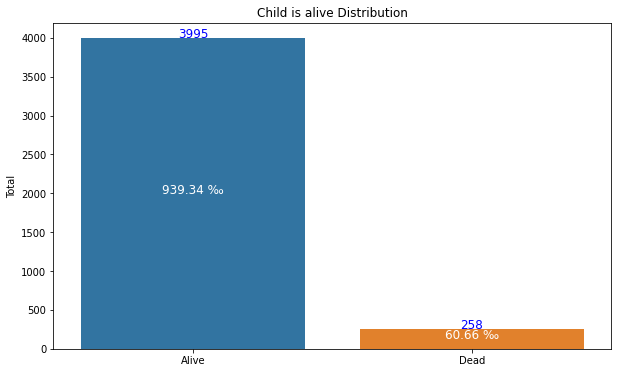

,Total,Per thousand
Alive,3995,939.336939
Dead,258,60.663061


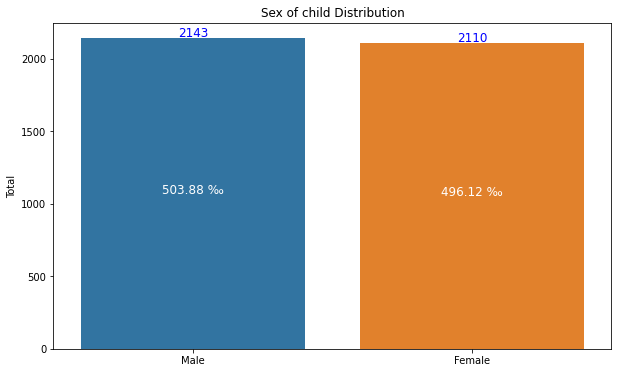

,Total,Per thousand
Male,2143,503.879614
Female,2110,496.120386


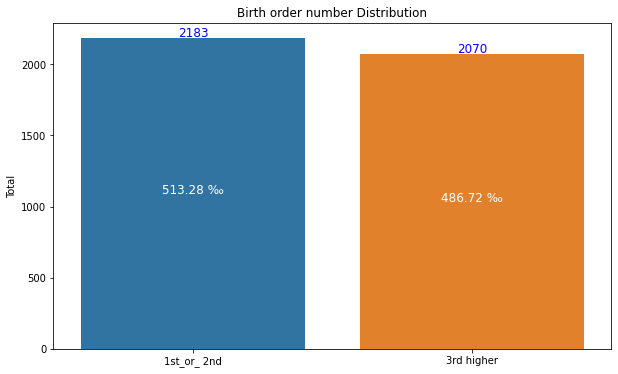

,Total,Per thousand
1st_or_ 2nd,2183,513.28474
3rd higher,2070,486.71526


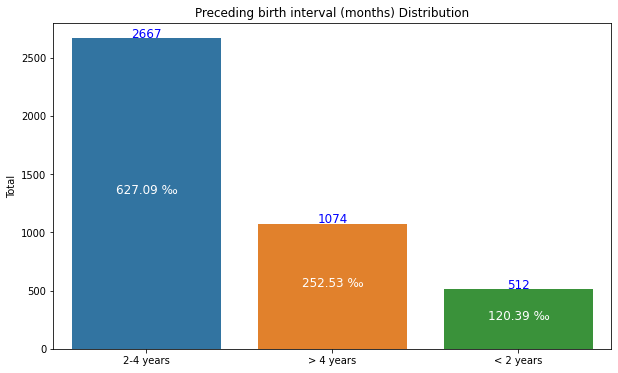

,Total,Per thousand
2-4 years,2667,627.086762
> 4 years,1074,252.527628
< 2 years,512,120.385610


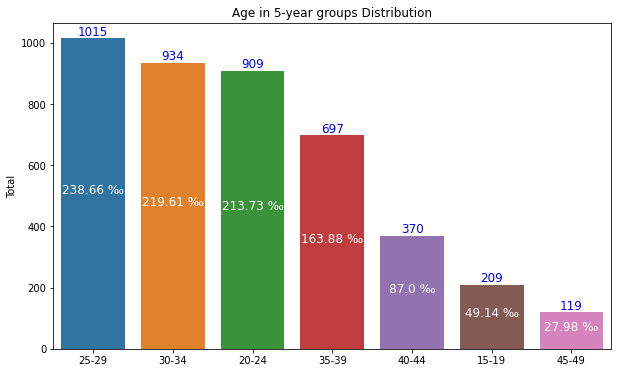

,Total,Per thousand
25-29,1015,238.655067
30-34,934,219.609687
20-24,909,213.731484
35-39,697,163.884317
40-44,370,86.997414
15-19,209,49.141782
45-49,119,27.980249


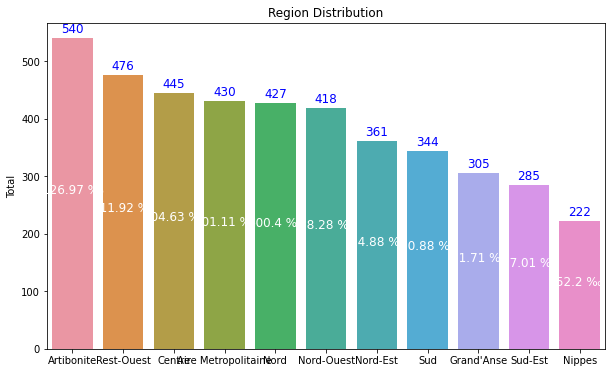

,Total,Per thousand
Artibonite,540,126.969198
Rest-Ouest,476,111.920997
Centre,445,104.632024
Aire Metropolitaine,430,101.105102
Nord,427,100.399718
Nord-Ouest,418,98.283565
Nord-Est,361,84.881260
Sud,344,80.884082
Grand'Anse,305,71.714084
Sud-Est,285,67.011521


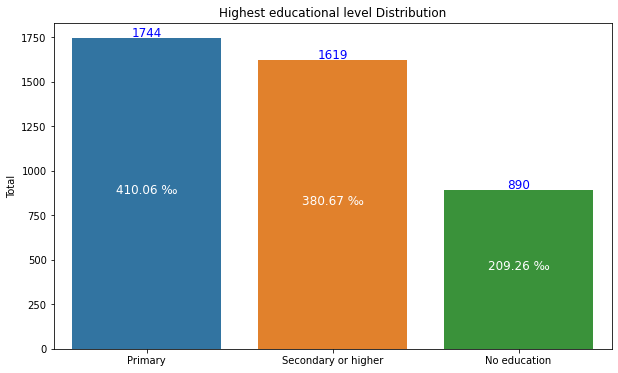

,Total,Per thousand
Primary,1744,410.063485
Secondary or higher,1619,380.672466
No education,890,209.264049


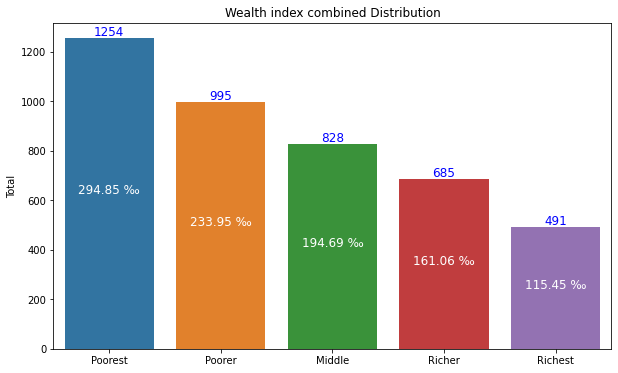

,Total,Per thousand
Poorest,1254,294.850694
Poorer,995,233.952504
Middle,828,194.686104
Richer,685,161.062779
Richest,491,115.447919


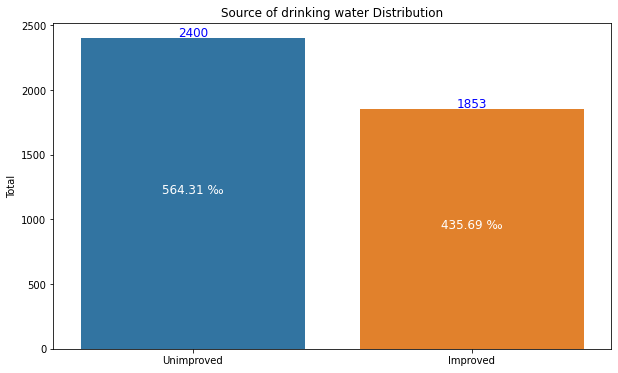

,Total,Per thousand
Unimproved,2400,564.307548
Improved,1853,435.692452


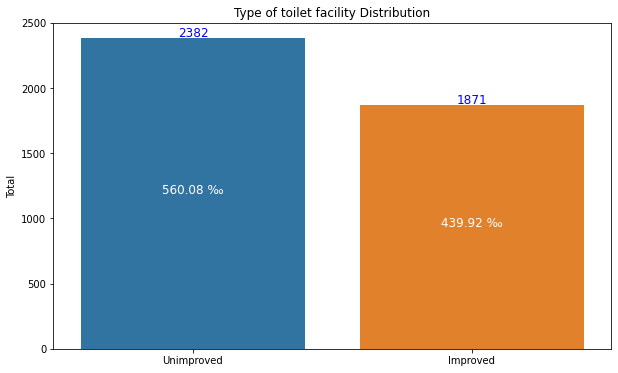

,Total,Per thousand
Unimproved,2382,560.075241
Improved,1871,439.924759


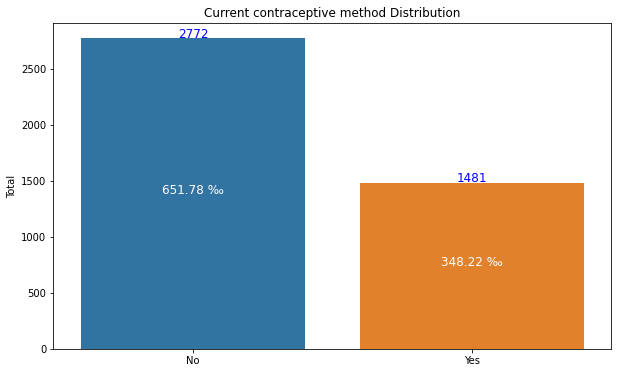

,Total,Per thousand
No,2772,651.775217
Yes,1481,348.224783


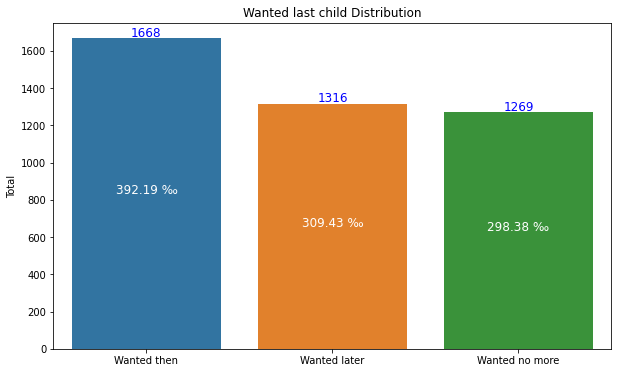

,Total,Per thousand
Wanted then,1668,392.193746
Wanted later,1316,309.428639
Wanted no more,1269,298.377616


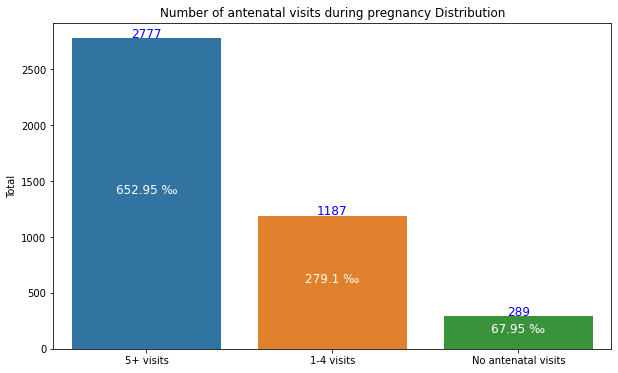

,Total,Per thousand
5+ visits,2777,652.950858
1-4 visits,1187,279.097108
No antenatal visits,289,67.952034


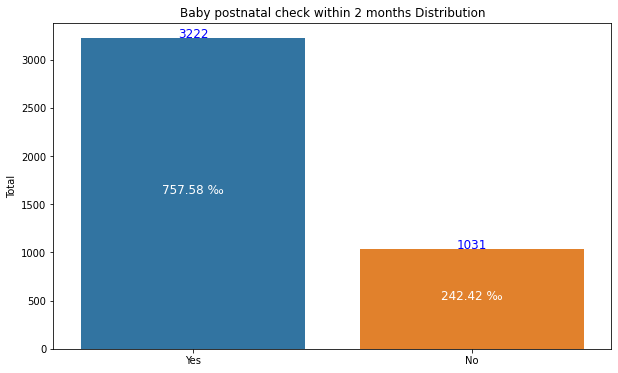

,Total,Per thousand
Yes,3222,757.582883
No,1031,242.417117


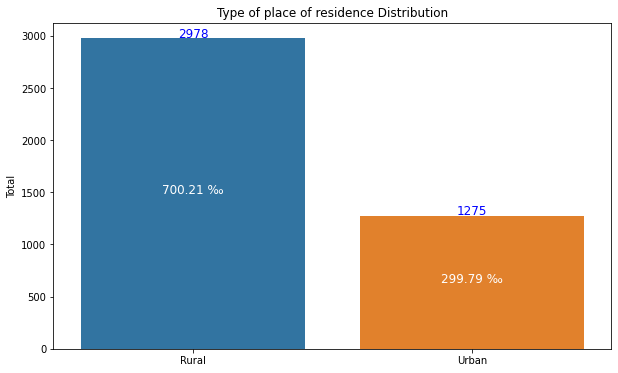

,Total,Per thousand
Rural,2978,700.211615
Urban,1275,299.788385


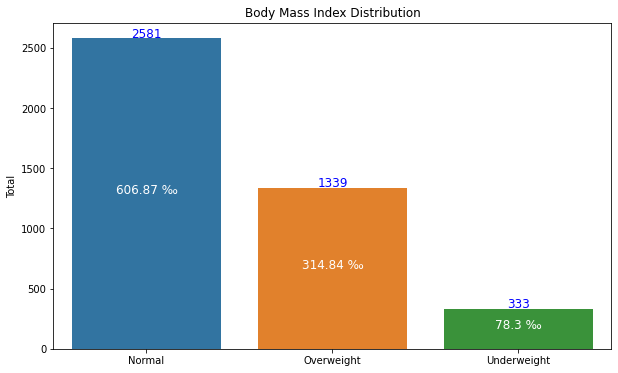

,Total,Per thousand
Normal,2581,606.865742
Overweight,1339,314.836586
Underweight,333,78.297672


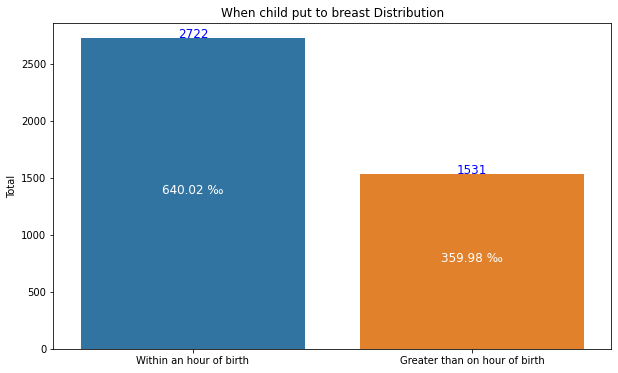

,Total,Per thousand
Within an hour of birth,2722,640.01881
Greater than on hour of birth,1531,359.98119


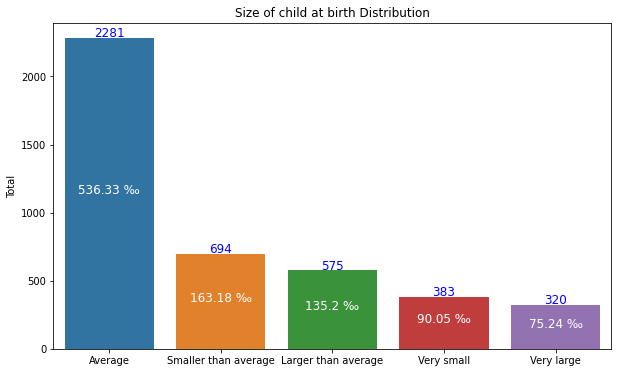

,Total,Per thousand
Average,2281,536.327298
Smaller than average,694,163.178933
Larger than average,575,135.198683
Very small,383,90.054079
Very large,320,75.241006


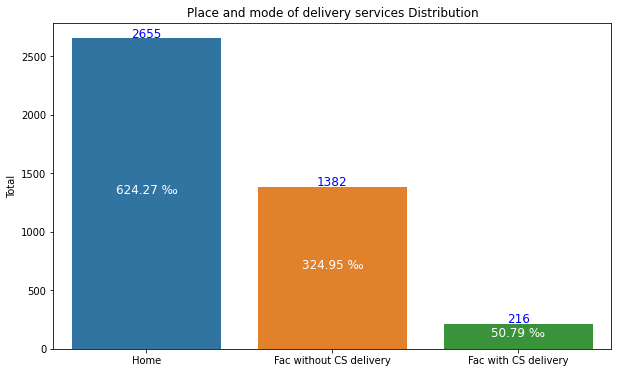

,Total,Per thousand
Home,2655,624.265225
Fac without CS delivery,1382,324.947096
Fac with CS delivery,216,50.787679


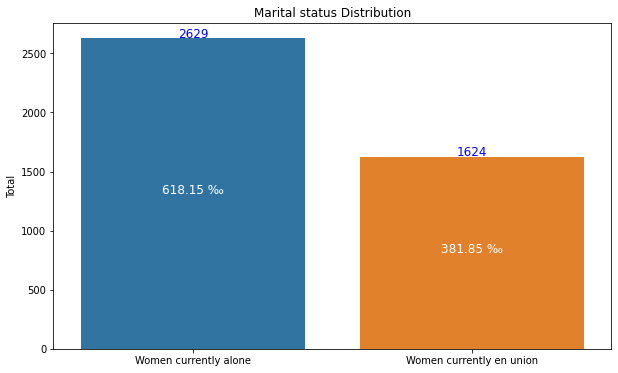

,Total,Per thousand
Women currently alone,2629,618.151893
Women currently en union,1624,381.848107


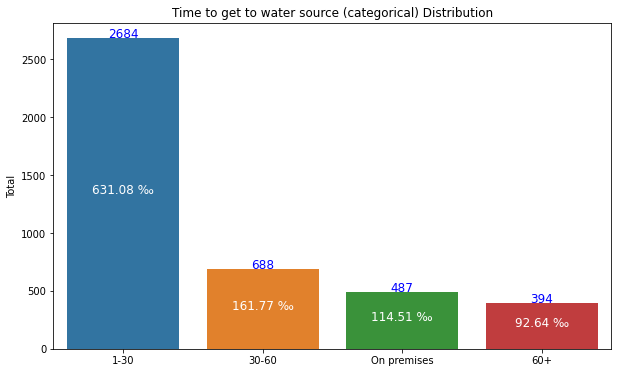

,Total,Per thousand
1-30,2684,631.083941
30-60,688,161.768164
On premises,487,114.507407
60+,394,92.640489


In [161]:
for cat_col in categorical_variables:
  result = univariate_analysis(data = data_selected, col=cat_col, abs_value ="Total",rel_value ="Per thousand",show_plot=True,title=f"{cat_col} Distribution")
  display(result)

### Violin plots are a combined form of box plots and KDE, which offer easy-to-understand analysis of the distribution:

<AxesSubplot:>

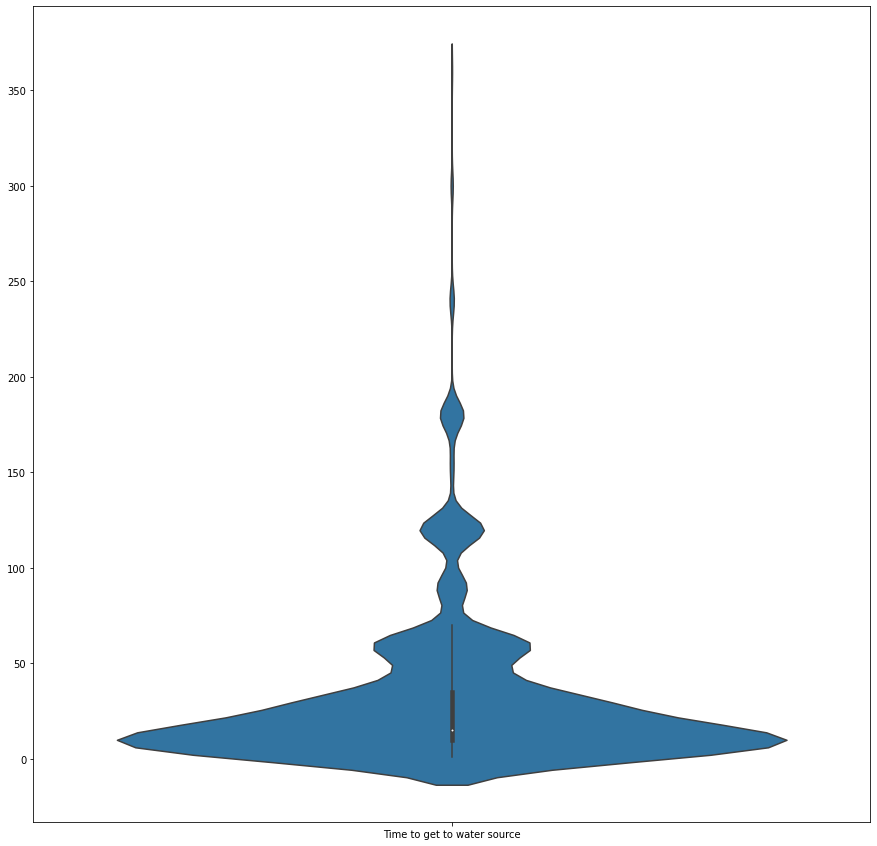

In [162]:
plt.figure(figsize=(15,15))
sns.violinplot(data=data_selected[["Time to get to water source"]])
#plt.title('Age boxplot for each communication channel')

<AxesSubplot:>

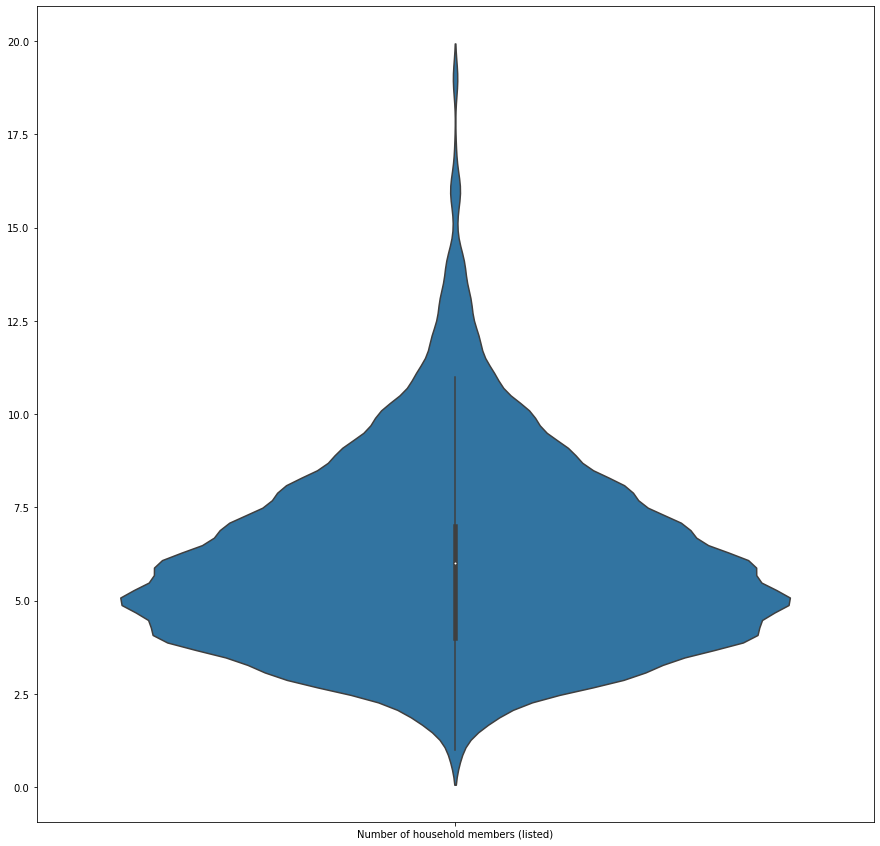

In [163]:
plt.figure(figsize=(15,15))
sns.violinplot(data=data_selected[["Number of household members (listed)"]])
#plt.title('Age boxplot for each communication channel')

### The joint plot is a multi-panel visualization; it shows the bivariate relationship and distribution of individual variables in a single graph.

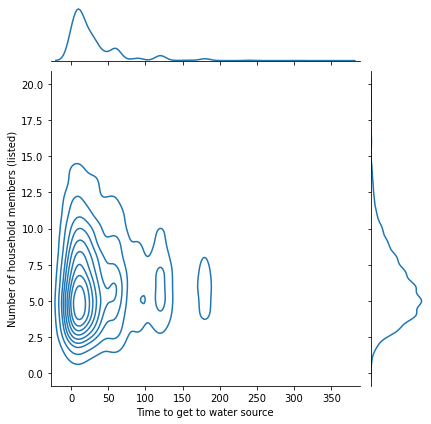

In [164]:
sns.jointplot(x="Time to get to water source", y="Number of household members (listed)", data=data_selected,kind="kde")

plt.show()


## Bivariate Analysis

A Chi-Square test is determined by a significant difference or relationship between two categorical variables from a single population. 
In general, this test assesses whether distributions of categorical variables differ from each other. 
It is also known as a Chi-Square goodness of fit test or a Chi-Square test for independence. 
A small value of the Chi-Square statistic means observed data fit with expected data, and a larger value of the Chi-Square statistic means observed data doesn't fit with expected data.

In [165]:
# We create a function to generate Pivot table, Chi-square tests & Bivariate BarPlot

categorical_var = ""
  
def my_chisqure_test(data=data_selected,columns=None,significance_level=0.05,figsize=(5,5),heatmap=False):

  result1  = pd.pivot_table(data=data,index=columns[0],columns=columns[1],values = "Time to get to water source",aggfunc="count",fill_value=0,margins = True)
  result2  = pd.pivot_table(data=data,index=columns[0],columns=columns[1],values = "Time to get to water source",aggfunc="count",fill_value=0)
  display(result1)
  
  

  stat, p, dof,s= chi2_contingency(result2) 
  print("p value: " + str(p)) 
  if p < significance_level: 
    print('We reject NULL HYPOTHESIS with a 95% confidence interval') 
    print(f"The two categorical variables are not independent—that is, {categorical_var} is not independent Whether the child is alive or not.")
  else: 
    print('We cannot reject NULL HYPOTHESIS with a 95% confidence interval') 
    print(f"The two categorical variables are independent—that is, {categorical_var} is independent Whether the child is alive or not.")

  # Force the aspect ratio of the blocks to be equal using "square" parameter


  
  plt.figure(figsize=figsize)
  if heatmap:
    ax = sns.heatmap(result1,cmap="YlGnBu", linewidths=.5,
    annot=True ,annot_kws={'size':14} ,fmt=".1f" , cbar=True ,square = True)
    plt.yticks(rotation=0)
  else:
    values = result1.iloc[:-1,:].sort_values(by =('Dead'),ascending=True)
    ax =values.sort_values(by =('Dead'),ascending=True)[[('Dead'),('Alive')]].plot(kind="barh",figsize=(15,10),stacked= True,alpha =0.7)
    ylab = ax.set_ylabel(f"{categorical_var}")
    xlab = ax.set_xlabel('Number chidren under five years old')
    title = ax.set_title(F"{categorical_var} according to whether the child is alive or not")

    index =0
    for Dead, Alive ,total in zip(values[('Dead')],values[('Alive')], values[('All')]):
      if Dead != total and  Alive != total  :
        ax.text(Dead/2 ,
                index,
                str(np.round((Dead/total)*1000,1)) + "‰",
                fontdict=dict(color='white',fontsize=10,horizontalalignment="center",verticalalignment="center")
                )
        ax.text(Dead + Alive/2 ,
              index,
              str(np.round((Alive/total)*1000,1)) + "‰",
              fontdict=dict(color='blue',fontsize=10,horizontalalignment="center",verticalalignment="center")
            )
      elif Alive == total:
        ax.text(Alive/2 ,
            index,
            str(np.round((Alive/total)*1000,1)) + "‰",
            fontdict=dict(color='blue',fontsize=10,horizontalalignment="center",verticalalignment="center")
          )
      else:
        ax.text(Dead/2 ,
            index,
            str(np.round((Dead/total)*1000,1)) + "‰",
            fontdict=dict(color='white',fontsize=10,horizontalalignment="center",verticalalignment="center")
          )       
  
    
      index+=1
  plt.show()



Child is alive,Alive,Dead,All
Sex of child,,,
Female,1998,112,2110
Male,1997,146,2143
All,3995,258,4253


p value: 0.046452365270653224
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Sex of child is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

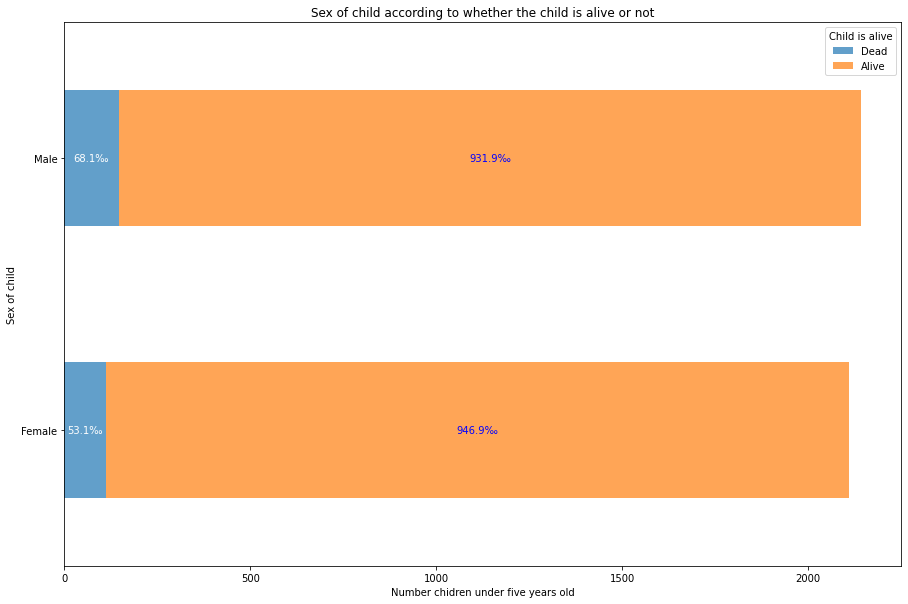

Child is alive,Alive,Dead,All
Birth order number,,,
1st_or_ 2nd,2078,105,2183
3rd higher,1917,153,2070
All,3995,258,4253


p value: 0.0005388641898118647
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Birth order number is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

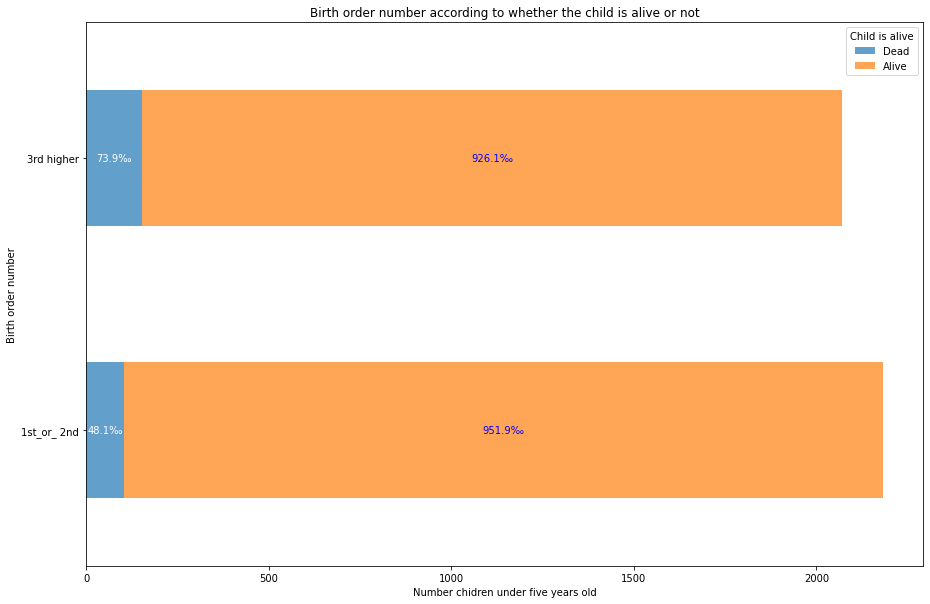

Child is alive,Alive,Dead,All
Preceding birth interval (months),,,
2-4 years,2504,163,2667
< 2 years,458,54,512
> 4 years,1033,41,1074
All,3995,258,4253


p value: 1.0262288322148567e-06
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Preceding birth interval (months) is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

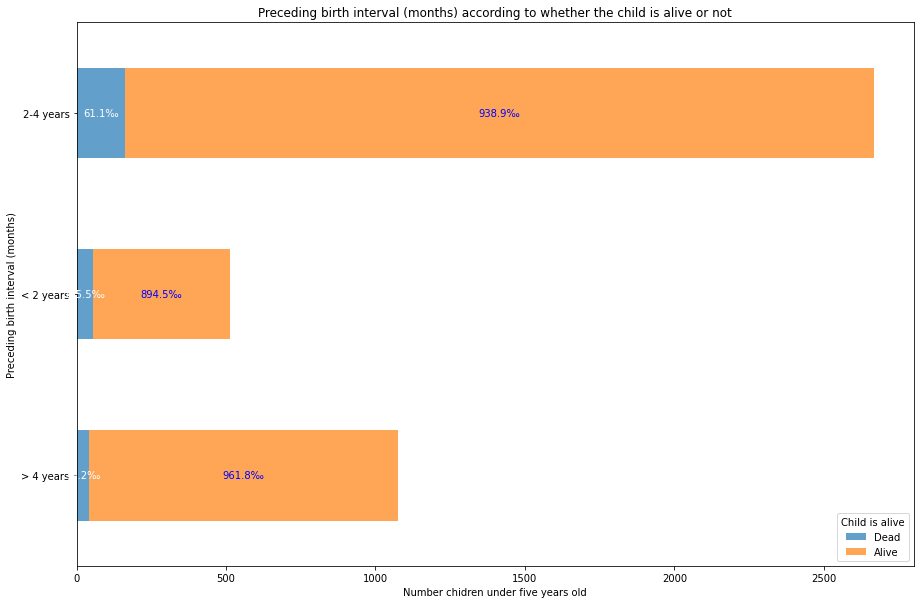

Child is alive,Alive,Dead,All
Age of respondent at 1st birth,,,
< 20 years,1811,125,1936
>= 20 years,2184,133,2317
All,3995,258,4253


p value: 0.3627168748746957
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Age of respondent at 1st birth is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

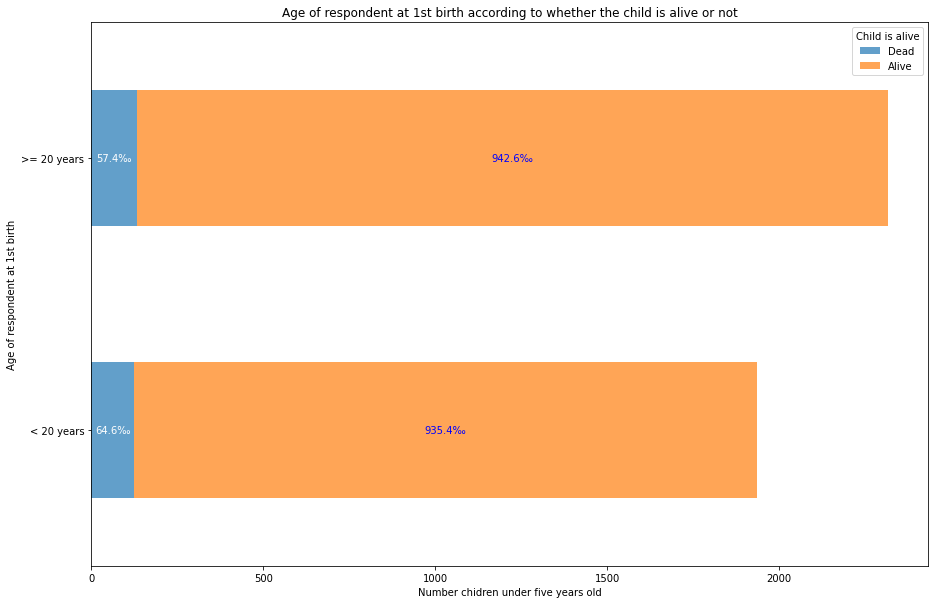

Child is alive,Alive,Dead,All
Age in 5-year groups,,,
15-19,193,16,209
20-24,862,47,909
25-29,967,48,1015
30-34,870,64,934
35-39,652,45,697
40-44,345,25,370
45-49,106,13,119
All,3995,258,4253


p value: 0.06591219974865832
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Age in 5-year groups is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

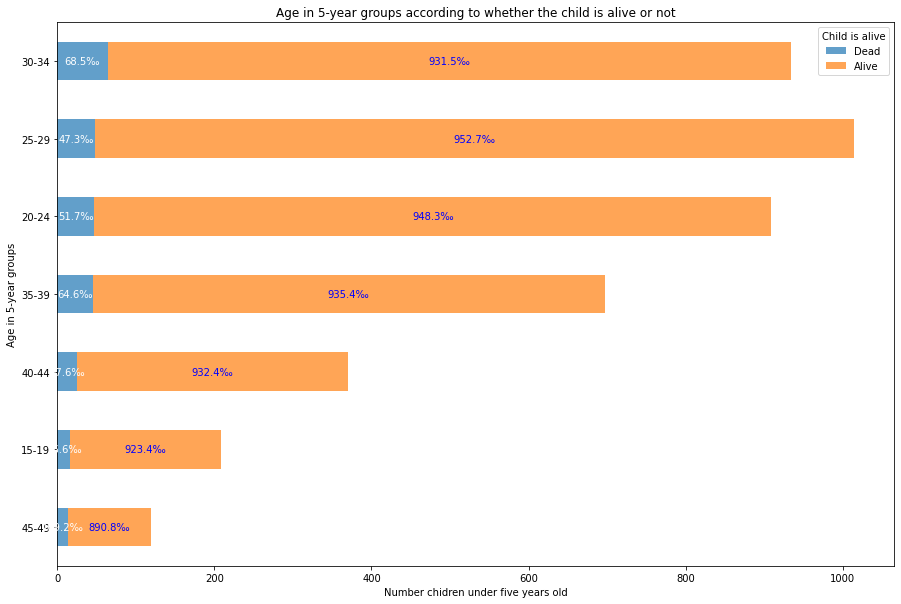

Child is alive,Alive,Dead,All
Region,,,
Aire Metropolitaine,397,33,430
Artibonite,509,31,540
Centre,413,32,445
Grand'Anse,298,7,305
Nippes,206,16,222
Nord,413,14,427
Nord-Est,341,20,361
Nord-Ouest,397,21,418
Rest-Ouest,427,49,476


p value: 0.00012028872066922267
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Region is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

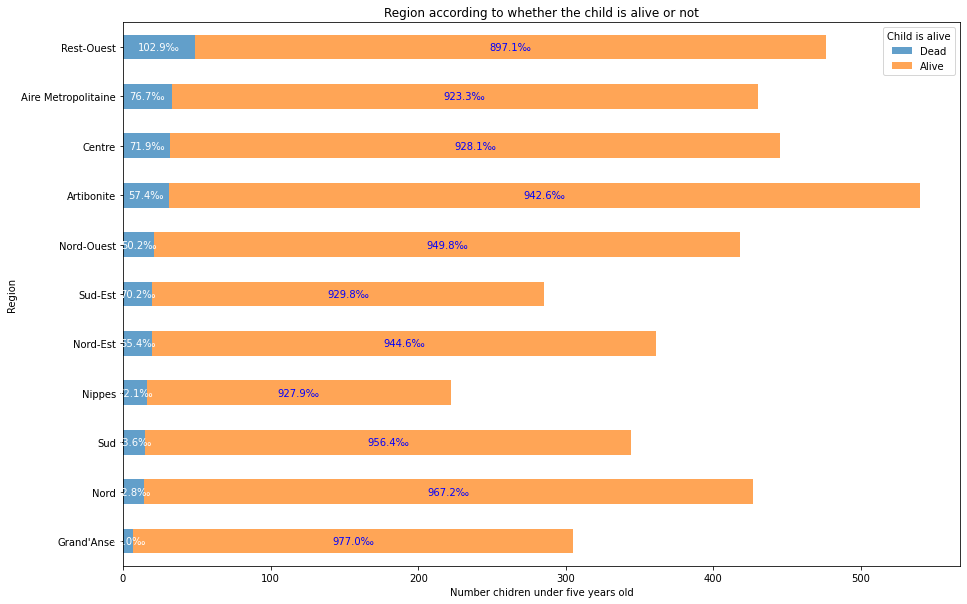

Child is alive,Alive,Dead,All
Highest educational level,,,
No education,827,63,890
Primary,1629,115,1744
Secondary or higher,1539,80,1619
All,3995,258,4253


p value: 0.04858642145331368
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Highest educational level is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

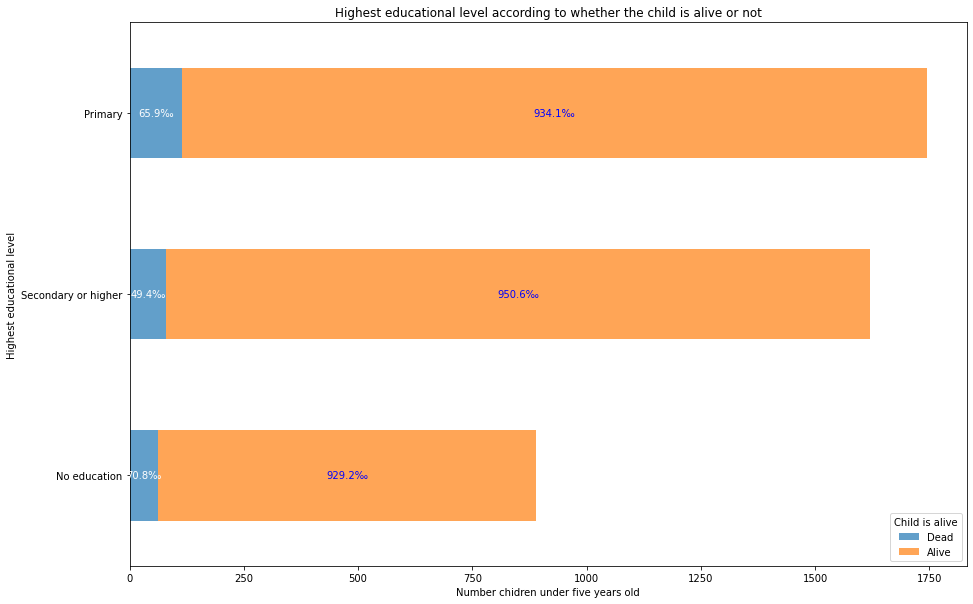

Child is alive,Alive,Dead,All
Wealth index combined,,,
Middle,782,46,828
Poorer,918,77,995
Poorest,1178,76,1254
Richer,647,38,685
Richest,470,21,491
All,3995,258,4253


p value: 0.07971996123299084
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Wealth index combined is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

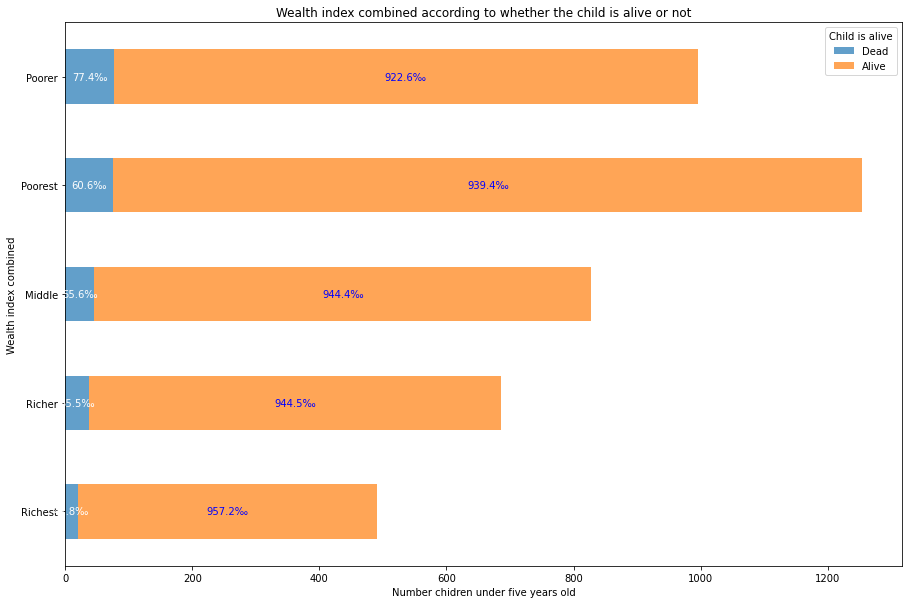

Child is alive,Alive,Dead,All
Source of drinking water,,,
Improved,1739,114,1853
Unimproved,2256,144,2400
All,3995,258,4253


p value: 0.8875680833697189
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Source of drinking water is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

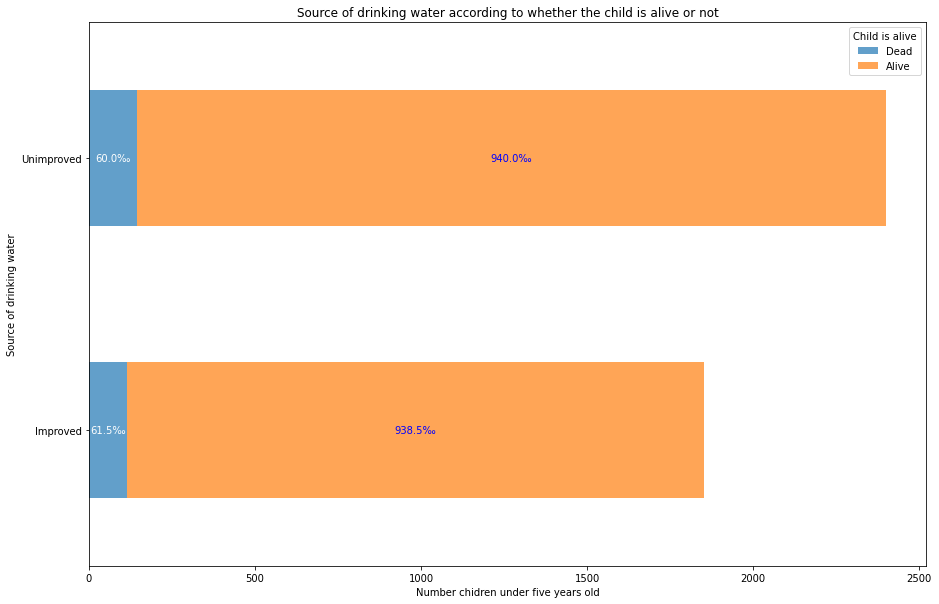

Child is alive,Alive,Dead,All
Births in last five years,,,
1,2293,95,2388
2,1427,113,1540
3,249,39,288
4,22,10,32
5,4,1,5
All,3995,258,4253


p value: 3.1713501269292805e-18
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Births in last five years is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

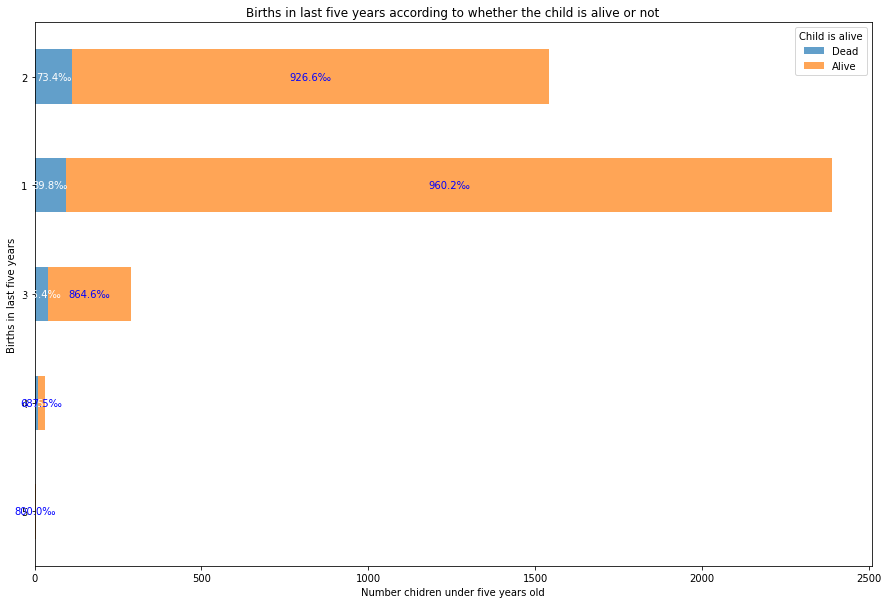

Child is alive,Alive,Dead,All
Type of toilet facility,,,
Improved,1770,101,1871
Unimproved,2225,157,2382
All,3995,258,4253


p value: 0.12042474012549283
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Type of toilet facility is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

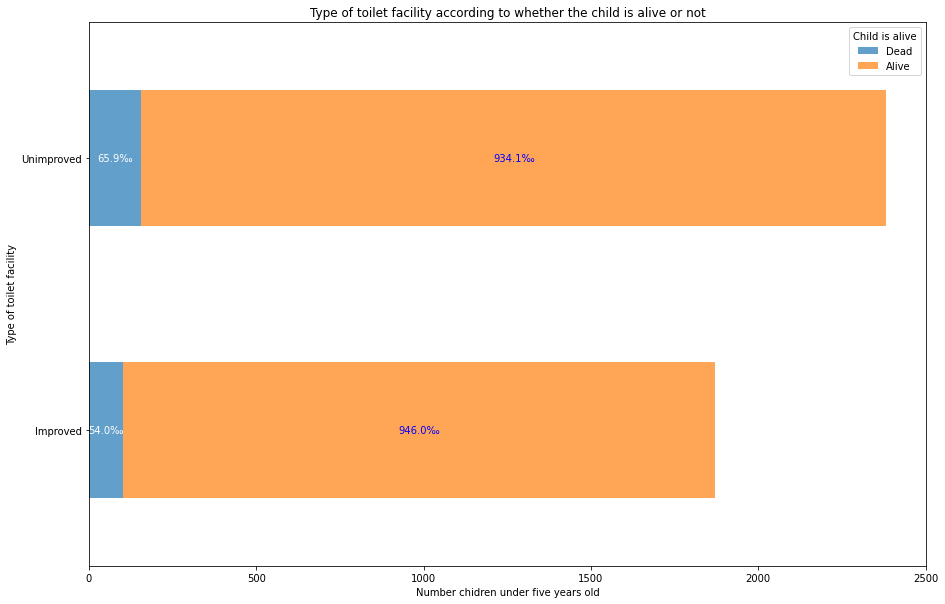

Child is alive,Alive,Dead,All
Current contraceptive method,,,
No,2572,200,2772
Yes,1423,58,1481
All,3995,258,4253


p value: 2.379044461955483e-05
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Current contraceptive method is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

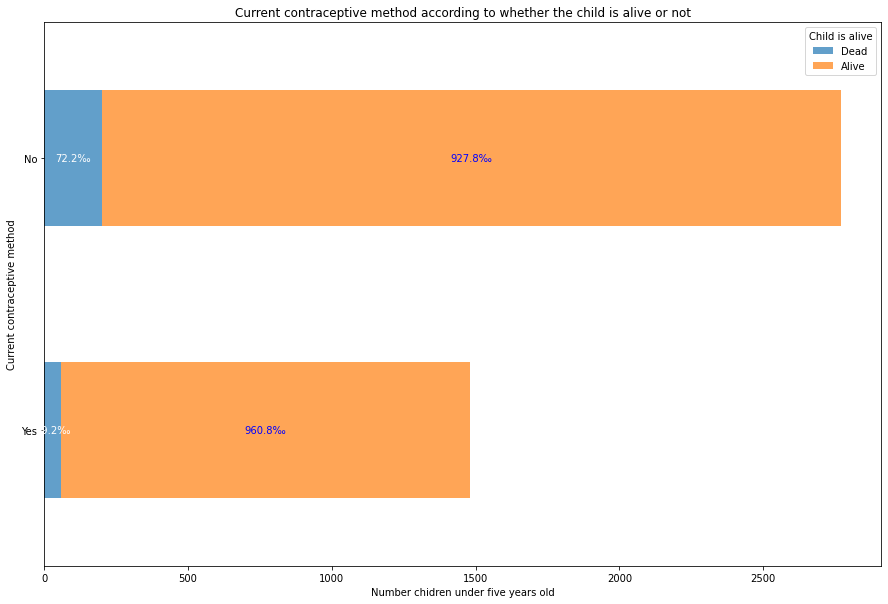

Child is alive,Alive,Dead,All
Wanted last child,,,
Wanted later,1246,70,1316
Wanted no more,1188,81,1269
Wanted then,1561,107,1668
All,3995,258,4253


p value: 0.3929382520740831
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Wanted last child is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

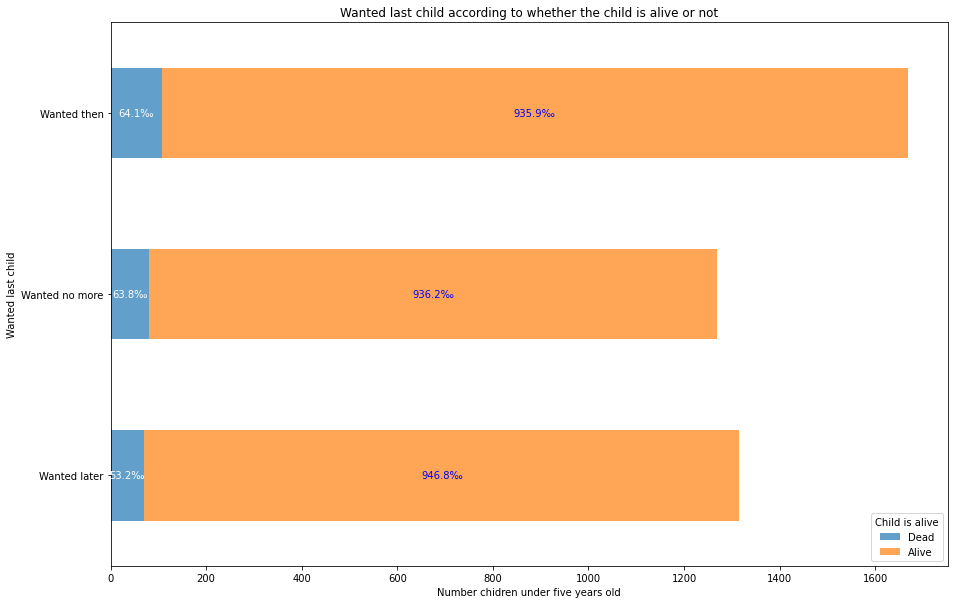

Child is alive,Alive,Dead,All
Number of antenatal visits during pregnancy,,,
1-4 visits,1127,60,1187
5+ visits,2606,171,2777
No antenatal visits,262,27,289
All,3995,258,4253


p value: 0.02219196814855903
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Number of antenatal visits during pregnancy is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

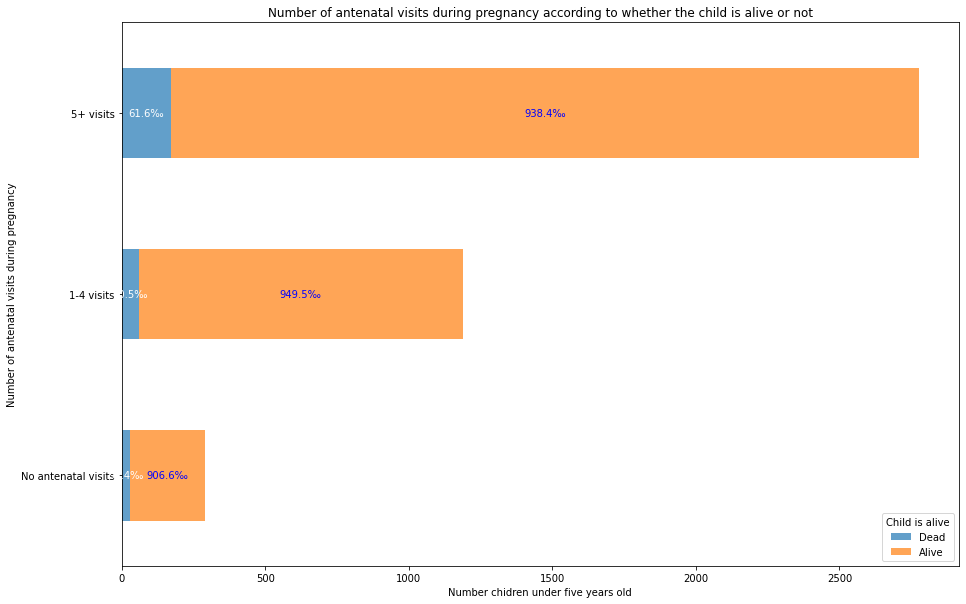

Child is alive,Alive,Dead,All
Baby postnatal check within 2 months,,,
No,952,79,1031
Yes,3043,179,3222
All,3995,258,4253


p value: 0.016767903033957778
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Baby postnatal check within 2 months is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

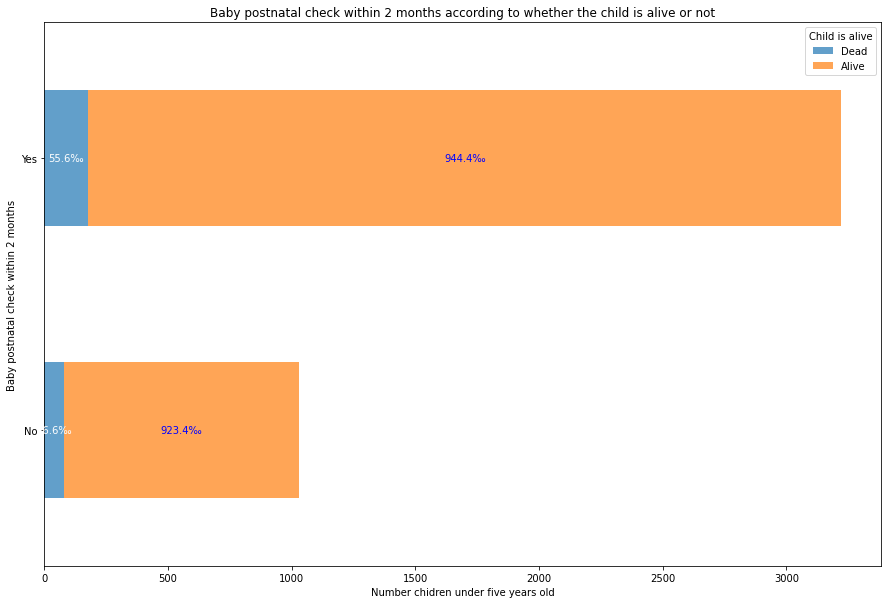

Child is alive,Alive,Dead,All
Type of place of residence,,,
Rural,2800,178,2978
Urban,1195,80,1275
All,3995,258,4253


p value: 0.7625903259524272
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Type of place of residence is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

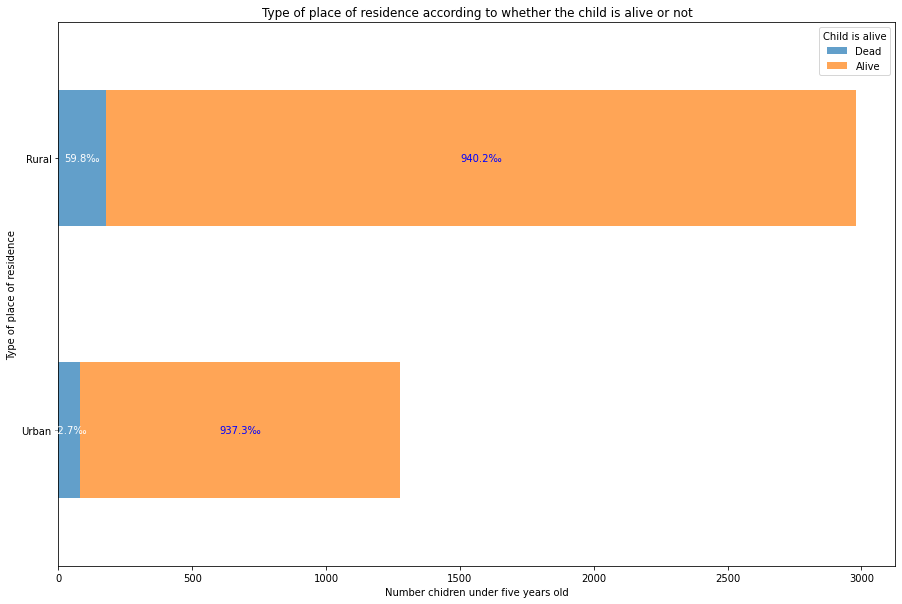

Child is alive,Alive,Dead,All
Body Mass Index,,,
Normal,2424,157,2581
Overweight,1265,74,1339
Underweight,306,27,333
All,3995,258,4253


p value: 0.20990443418045374
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Body Mass Index is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

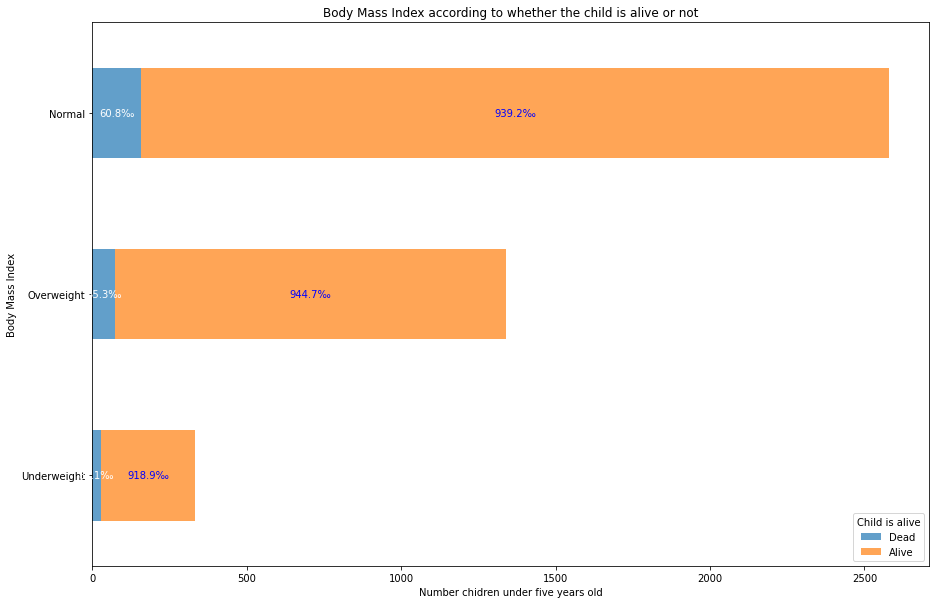

Child is alive,Alive,Dead,All
When child put to breast,,,
Greater than on hour of birth,1408,123,1531
Within an hour of birth,2587,135,2722
All,3995,258,4253


p value: 7.351911812354136e-05
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, When child put to breast is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

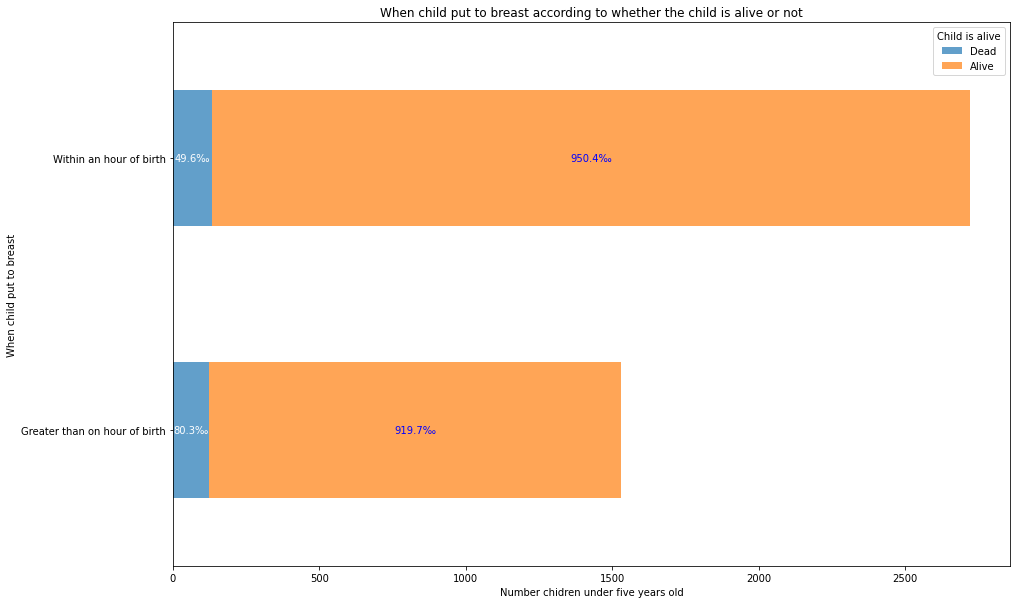

Child is alive,Alive,Dead,All
Size of child at birth,,,
Average,2148,133,2281
Larger than average,544,31,575
Smaller than average,654,40,694
Very large,302,18,320
Very small,347,36,383
All,3995,258,4253


p value: 0.0789238332099538
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Size of child at birth is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

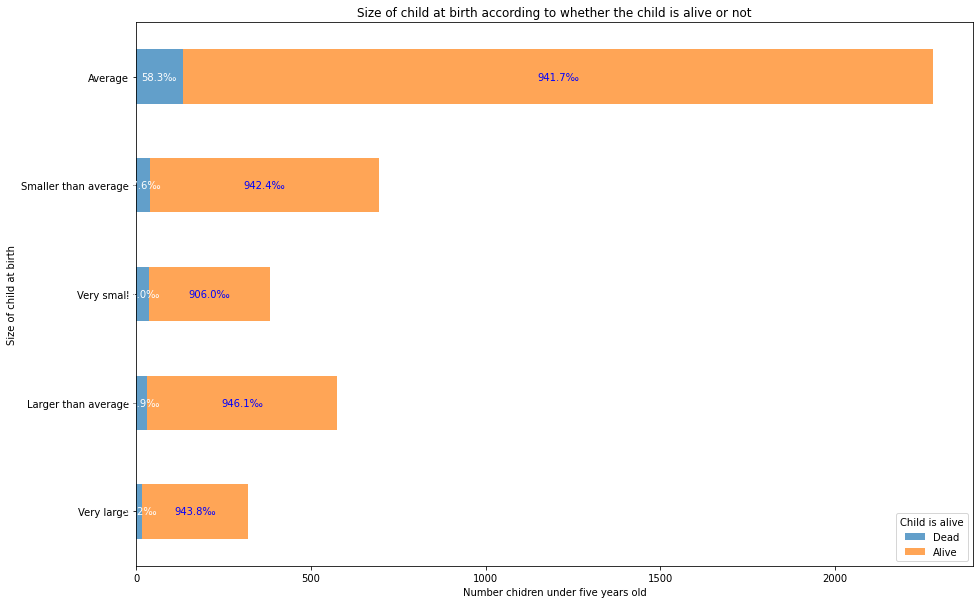

Child is alive,Alive,Dead,All
Place and mode of delivery services,,,
Fac with CS delivery,207,9,216
Fac without CS delivery,1317,65,1382
Home,2471,184,2655
All,3995,258,4253


p value: 0.009318064089361266
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Place and mode of delivery services is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

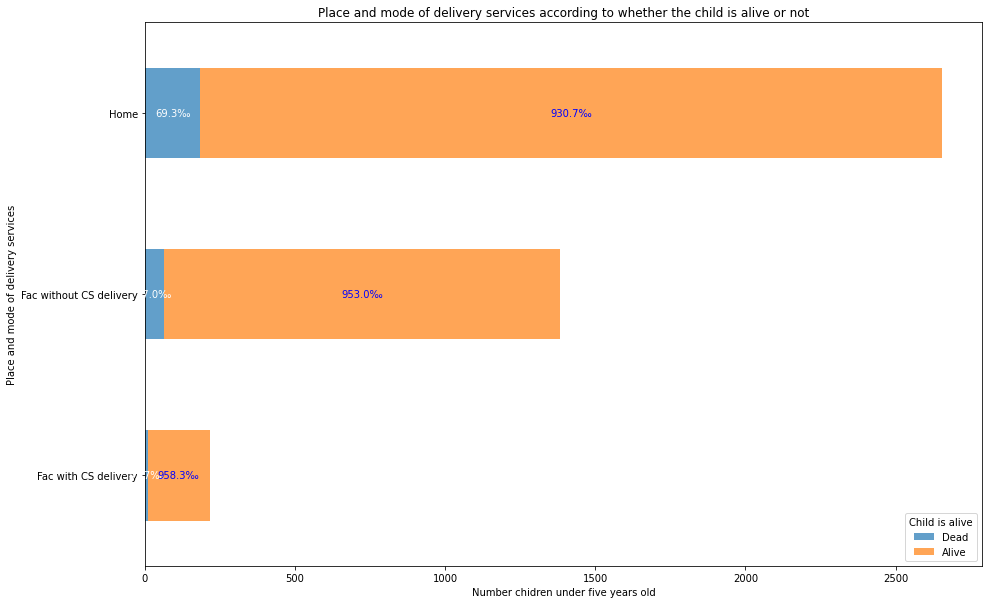

Child is alive,Alive,Dead,All
Marital status,,,
Women currently alone,2461,168,2629
Women currently en union,1534,90,1624
All,3995,258,4253


p value: 0.28916420950297916
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Marital status is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

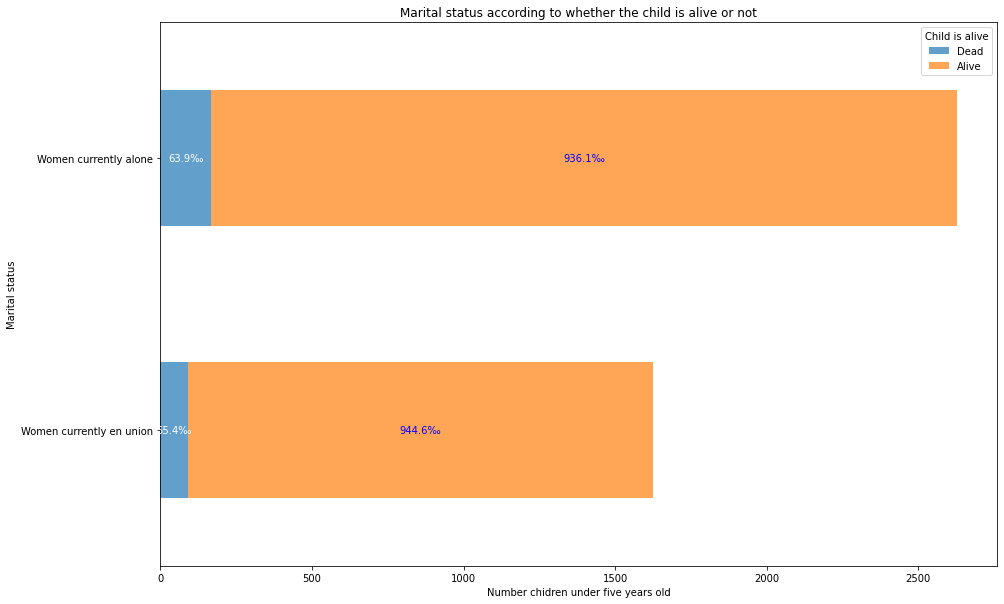

Child is alive,Alive,Dead,All
Number of household members (listed),,,
1,13,2,15
2,80,19,99
3,382,37,419
4,655,37,692
5,724,52,776
6,640,39,679
7,494,25,519
8,378,16,394
9,244,16,260


p value: 2.3497442692870475e-05
We reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are not independent—that is, Number of household members (listed) is not independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

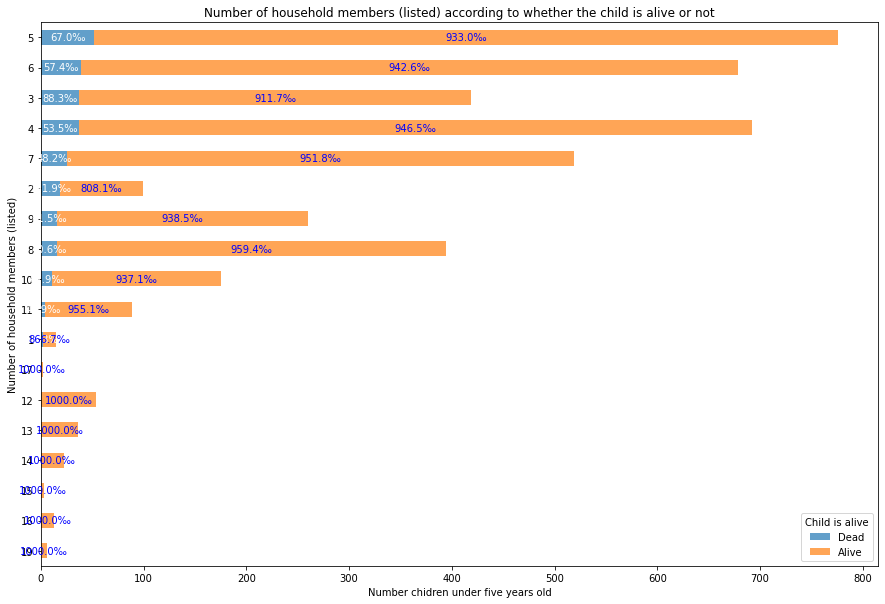

Child is alive,Alive,Dead,All
Time to get to water source (categorical),,,
1-30,2525,159,2684
30-60,648,40,688
60+,361,33,394
On premises,461,26,487
All,3995,258,4253


p value: 0.22968354496068769
We cannot reject NULL HYPOTHESIS with a 95% confidence interval
The two categorical variables are independent—that is, Time to get to water source (categorical) is independent Whether the child is alive or not.


<Figure size 360x1080 with 0 Axes>

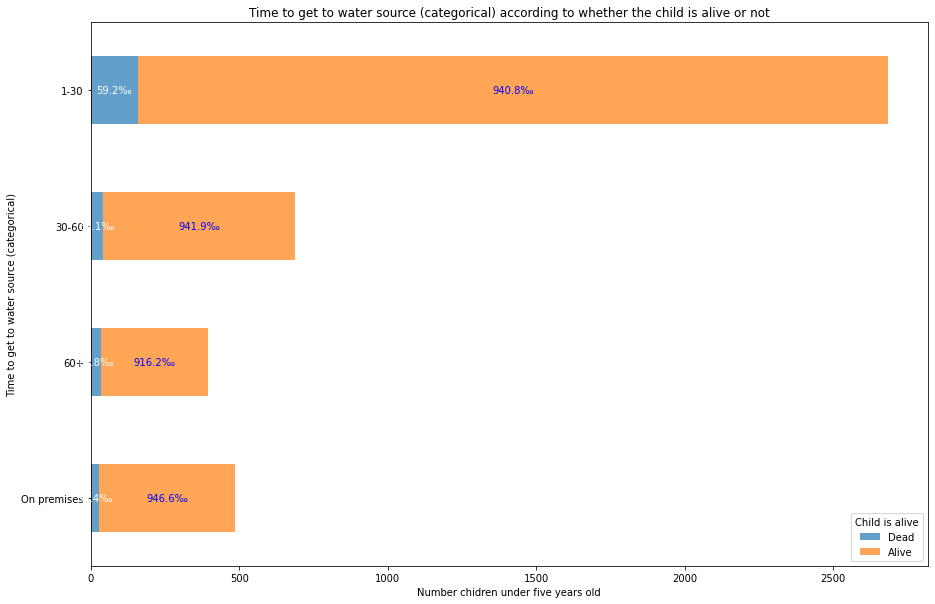

In [166]:

chiSquareVar = ["Sex of child", "Birth order number", "Preceding birth interval (months)", "Age of respondent at 1st birth", "Age in 5-year groups", "Region", "Highest educational level", "Wealth index combined", "Source of drinking water", "Births in last five years", "Type of toilet facility", "Current contraceptive method", "Wanted last child", "Number of antenatal visits during pregnancy", "Baby postnatal check within 2 months", "Type of place of residence", "Body Mass Index", "When child put to breast", "Size of child at birth", "Place and mode of delivery services", "Marital status", "Number of household members (listed)", "Time to get to water source (categorical)"]


for categorical_var in chiSquareVar:
    my_chisqure_test(data_selected,columns=[f"{categorical_var}", "Child is alive"],significance_level=0.05,figsize=(5,15),heatmap=False)

<AxesSubplot:xlabel='Child is alive', ylabel='Number of household members (listed)'>

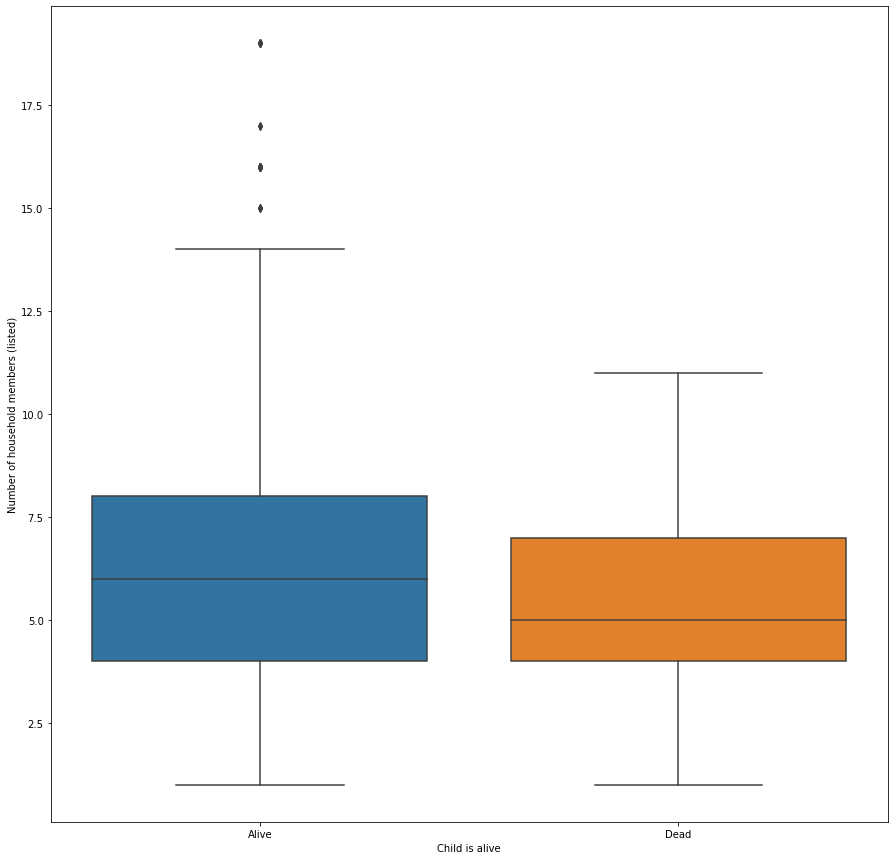

In [167]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data_selected,x="Child is alive",y="Number of household members (listed)")
#plt.title('Age boxplot for each communication channel')

In [168]:
avg = data_selected['Time to get to water source'].mean()
print('The average time to get to water source in the whole dataset is', np.round(avg,2), 'minutes')

var = data_selected['Time to get to water source'].var()
print('The Time to get to water source variance of the observations in the whole dataset is', np.round(var,2))

kurtosis = data_selected['Time to get to water source'].kurtosis()
print('The kurtosis Time to get to water source of the  distribution the whole dataset is', np.round(kurtosis,2))

skewness = data_selected['Time to get to water source'].skew()
print('The skewness Time to get to water source of the distribution in the whole dataset is', np.round(skewness,2))

The average time to get to water source in the whole dataset is 30.66 minutes
The Time to get to water source variance of the observations in the whole dataset is 1483.99
The kurtosis Time to get to water source of the  distribution the whole dataset is 10.75
The skewness Time to get to water source of the distribution in the whole dataset is 2.8


<Figure size 2160x2160 with 0 Axes>

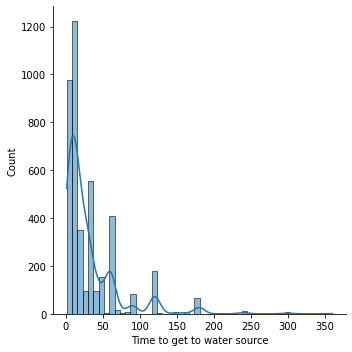

In [169]:
plt.figure(figsize=(30,30))
bins = 50
sns.displot(data_selected['Time to get to water source'],bins = bins,kde = True)
plt.show()

### ANOVA

ANOVA: A t-test only deals with two groups, but sometimes we have more than
two groups or multiple groups at the same time to compare. ANOVA (ANalysis
Of VAriance) is a statistical inference test used for comparing multiple groups. It
analyzes the variance between and within multiple groups and tests several null
hypotheses at the same time. It usually compares more than two sets of data and
checks statistical significance. We can use ANOVA in three ways: one-way
ANOVA, two-way ANOVA, and N-way multivariate ANOVA.


With the one-way ANOVA method, we compare multiple groups based on only
one independent variable.


Null Hypothesis H0: 
    There is no difference between the mean of the two groups 
Alternative Hypothesis Ha: 
    There is a difference between the mean of the two groups



In [170]:
# Average time to get water by selected socioeconomic characteristics

display(data_selected["Time to get to water source"].groupby(by= data_selected['Child is alive']).mean())
display(data_selected["Time to get to water source"].groupby(by= data_selected["Region"]).mean())
display(data_selected["Time to get to water source"].groupby(by= data_selected["Type of place of residence"]).mean())
display(data_selected["Time to get to water source"].groupby(by= data_selected["Highest educational level"]).mean())
display(data_selected["Time to get to water source"].groupby(by= data_selected["Wealth index combined"]).mean())
display(data_selected["Time to get to water source"].groupby(by= data_selected["Source of drinking water"]).mean())


Child is alive
Alive    30.384731
Dead     34.976744
Name: Time to get to water source, dtype: float64

Region
Aire Metropolitaine    17.102326
Artibonite             29.287037
Centre                 32.829213
Grand'Anse             39.285246
Nippes                 26.085586
Nord                   23.847775
Nord-Est               18.861496
Nord-Ouest             35.892344
Rest-Ouest             37.130252
Sud                    28.845930
Sud-Est                53.571930
Name: Time to get to water source, dtype: float64

Type of place of residence
Rural    37.156817
Urban    15.496471
Name: Time to get to water source, dtype: float64

Highest educational level
No education           36.938202
Primary                35.077982
Secondary or higher    22.458308
Name: Time to get to water source, dtype: float64

Wealth index combined
Middle     24.247585
Poorer     39.930653
Poorest    42.646730
Richer     14.970803
Richest    13.989817
Name: Time to get to water source, dtype: float64

Source of drinking water
Improved      29.554236
Unimproved    31.519583
Name: Time to get to water source, dtype: float64

In [171]:

timeByRegion = data_selected["Time to get to water source"].groupby(by= data_selected["Region"]).mean().to_frame()




Is there a significant mean Time to get to water difference between these groups: Alive/Death?

In [172]:
# We put in variable the values of each group, Then we do the ANOVA test

Alive_list_time = data_selected[data_selected['Child is alive'] == 'Alive']['Time to get to water source'].values
Death_list_time = data_selected[data_selected['Child is alive'] == 'Dead']['Time to get to water source'].values

# Ho : There is no difference between the mean of these groups
# Ha : There is a difference between the mean of these groups

stat, p = f_oneway(Alive_list_time, Death_list_time )

print("p-values:", p)
print("ANOVA:", stat)


# Decision Rule

if p < 0.05:
 print("Hypothesis Ho Rejected, There is a difference between the mean of these groups")
else:
 print("Hypothesis Ho cannot be Rejected, There is no difference between the mean of these groups")

p-values: 0.06348924370592576
ANOVA: 3.4456076377094056
Hypothesis Ho cannot be Rejected, There is no difference between the mean of these groups


In [173]:
# Average number of children per household by selected socioeconomic characteristics

display(data_selected["Number of household members (listed)"].groupby(by= data_selected['Child is alive']).mean())
display(data_selected["Number of household members (listed)"].groupby(by= data_selected["Region"]).mean())
display(data_selected["Number of household members (listed)"].groupby(by= data_selected["Type of place of residence"]).mean())
display(data_selected["Number of household members (listed)"].groupby(by= data_selected["Highest educational level"]).mean())
display(data_selected["Number of household members (listed)"].groupby(by= data_selected["Wealth index combined"]).mean())

Child is alive
Alive    6.126909
Dead     5.403101
Name: Number of household members (listed), dtype: float64

Region
Aire Metropolitaine    5.258140
Artibonite             5.870370
Centre                 6.155056
Grand'Anse             6.298361
Nippes                 5.761261
Nord                   6.613583
Nord-Est               6.307479
Nord-Ouest             6.248804
Rest-Ouest             5.781513
Sud                    6.529070
Sud-Est                6.280702
Name: Number of household members (listed), dtype: float64

Type of place of residence
Rural    6.252854
Urban    5.686275
Name: Number of household members (listed), dtype: float64

Highest educational level
No education           6.391011
Primary                6.137041
Secondary or higher    5.855466
Name: Number of household members (listed), dtype: float64

Wealth index combined
Middle     5.985507
Poorer     6.219095
Poorest    6.301435
Richer     5.731387
Richest    5.904277
Name: Number of household members (listed), dtype: float64

Is there a significant mean Number of household members (listed) difference between these groups: Alive/Death?

In [174]:
# We put in variable the values of each group, Then we do the ANOVA test

Alive_list_household_members = data_selected[data_selected['Child is alive'] == 'Alive']["Number of household members (listed)"].values
Death_list_household_members = data_selected[data_selected['Child is alive'] == 'Dead']["Number of household members (listed)"].values

# Ho : There is no difference between the mean of these groups
# Ha : There is a difference between the mean of these groups

stat, p = f_oneway(Alive_list_household_members, Death_list_household_members)
print("p-values:", p)
print("ANOVA:", stat)

# Decision Rule

if p < 0.05:
 print("Hypothesis Ho Rejected, There is a difference between the mean of these groups")
else:
 print("Hypothesis Ho cannot be Rejected, There is no difference between the mean of these groups")

p-values: 6.54503298223063e-06
ANOVA: 20.372860415430335
Hypothesis Ho Rejected, There is a difference between the mean of these groups


### Multivariate Analysis

### Others insights

In [175]:
# We reduce the dataset to child mortality for further study

MortalityUnderFive = data_selected["Child is alive"] == "Dead"
death_children =data_selected[MortalityUnderFive]

Neonatal mortality: the probability of dying at birth before reaching one month.

Post-neonatal mortality: probability of dying between the first month and the first birthday (calculated as the difference between infant and neonatal mortality rates).

Infant mortality: probability of dying between birth and the first birthday.

Child mortality: probability of dying between the first and fifth birthdays.

Infant-child mortality: probability of dying between birth and the fifth birthday.

In [176]:

death_children['Age at death (months, imputed)'].value_counts()

0.0     114
3.0      18
1.0      17
24.0     15
7.0      13
6.0      11
12.0      9
5.0       9
2.0       9
9.0       7
36.0      6
10.0      4
11.0      4
18.0      4
13.0      4
4.0       3
14.0      2
16.0      2
15.0      2
8.0       1
17.0      1
21.0      1
20.0      1
48.0      1
Name: Age at death (months, imputed), dtype: int64

In [177]:
#  The function that groups in 3 modalities

def type_of_mortality(x):

    try:
        x=float(x)
        if x < 1.0:
            return "Neonatal mortality"
        elif x >= 1.0 and x <= 12:
            return "Post-neonatal mortality"
        else:
            return "Child mortality"

    except:
        print(x)
        return 'Unknown'
        
death_children['Age at death (months, imputed)'] = death_children['Age at death (months, imputed)'].apply(type_of_mortality)

C:\Users\bootcamp\AppData\Local\Temp/ipykernel_21184/1165634377.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_children['Age at death (months, imputed)'] = death_children['Age at death (months, imputed)'].apply(type_of_mortality)


In [178]:
death_children['Age at death (months, imputed)'].value_counts(normalize=True)*1000

Neonatal mortality         441.860465
Post-neonatal mortality    406.976744
Child mortality            151.162791
Name: Age at death (months, imputed), dtype: float64

In [179]:
def dead_category(data,col="Sex of child", abs_value ="Total",rel_value ="Per thousand",show_plot=False, title=""):
  # absolute value
   res1 = data[col].value_counts().to_frame()
   res1.columns = [abs_value]

   res2 = data[col].value_counts(normalize=True).to_frame()
   res2= res2*1000
   res2.columns = [rel_value]

   if  not show_plot:
     return pd.concat([res1,res2],axis=1)
   else:
     outcome = pd.concat([res1,res2],axis=1)
     generate_barchart(data=outcome, title =title,abs_value =abs_value,rel_value=rel_value,figsize =(15,10))
     return outcome




def generate_barchart(data=None, title ="",abs_value ="Total",rel_value="Per thousand",figsize =(15,10)):
  plt.figure(figsize=figsize)
  axes = sns.barplot(data=data,x=data.index,y=abs_value)
  i=0
  color ="White"
  for tot, perc in zip(data[abs_value],data[rel_value]):
    if tot/2 <= 25:
      
      color ="gray"

    axes.text(i,
              tot/2,
              str(np.round(perc,2))+ " ‰",
               fontdict=dict(color=color,fontsize=12,horizontalalignment="center")
              )
    axes.text(i,
              tot+ 10,
              str(tot),
               fontdict=dict(color='blue',fontsize=12,horizontalalignment="center")
              )
    
    i+=1
  plt.title(title)
  plt.show()

In [180]:
cat_cols = ['Age at death (months, imputed)', "Sex of child", "Birth order number", "Preceding birth interval (months)", "Age of respondent at 1st birth", "Age in 5-year groups", "Region", "Highest educational level", "Wealth index combined", "Source of drinking water", "Births in last five years", "Type of toilet facility", "Current contraceptive method", "Wanted last child", "Number of antenatal visits during pregnancy", "Baby postnatal check within 2 months", "Type of place of residence", "Body Mass Index", "When child put to breast", "Size of child at birth", "Place and mode of delivery services", "Marital status", "Number of household members (listed)", "Time to get to water source (categorical)"]

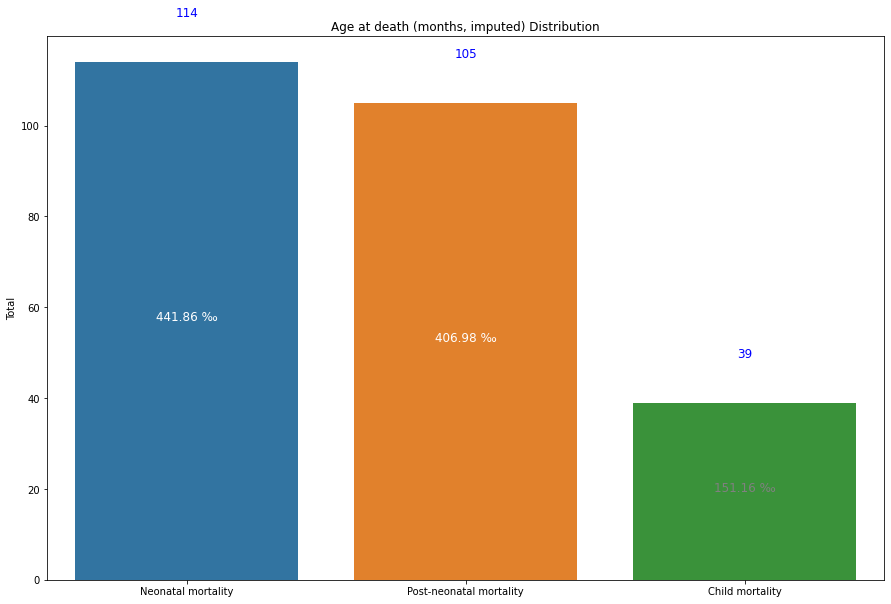

,Total,Per thousand
Neonatal mortality,114,441.860465
Post-neonatal mortality,105,406.976744
Child mortality,39,151.162791


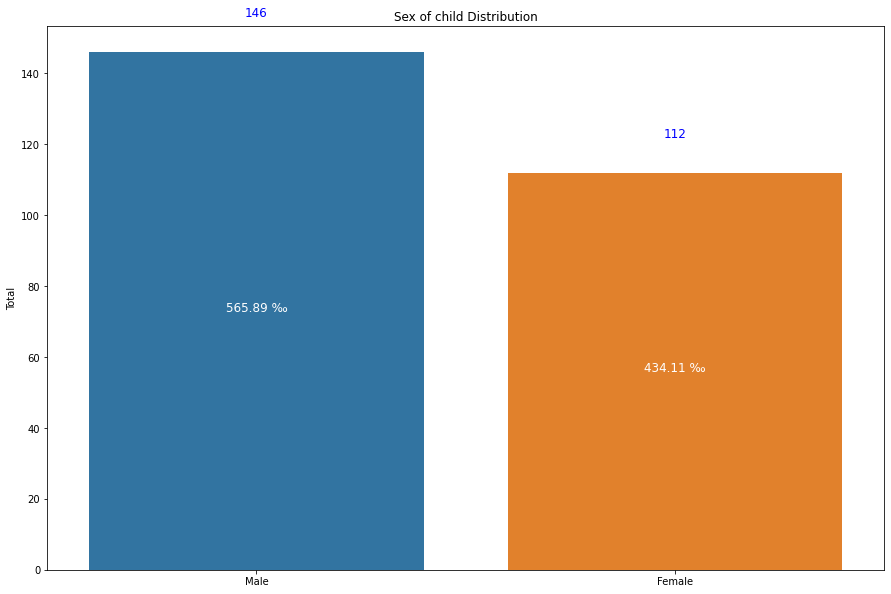

,Total,Per thousand
Male,146,565.891473
Female,112,434.108527


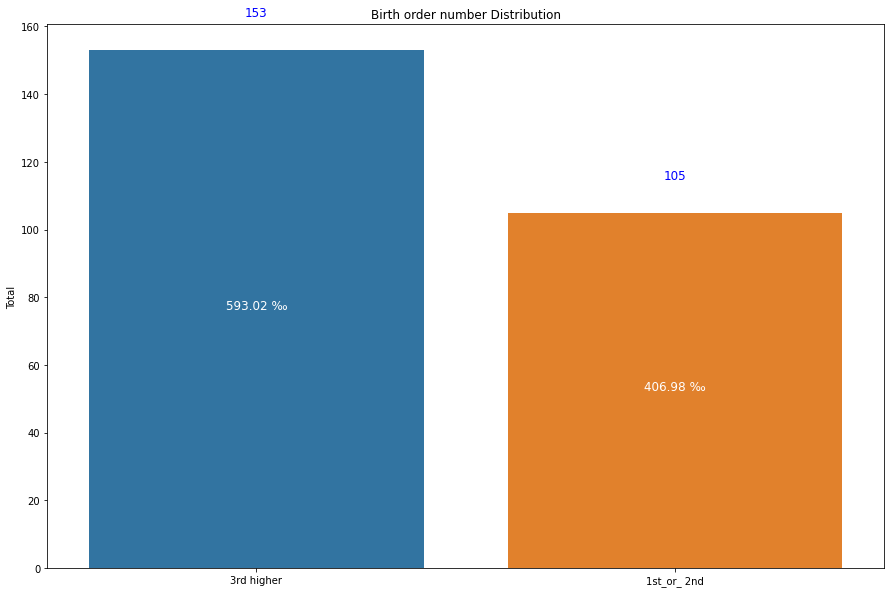

,Total,Per thousand
3rd higher,153,593.023256
1st_or_ 2nd,105,406.976744


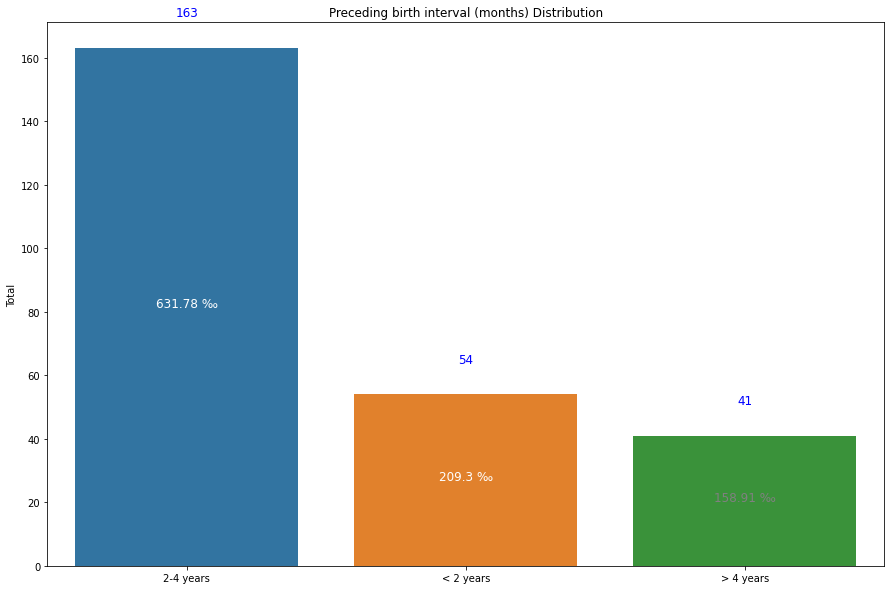

,Total,Per thousand
2-4 years,163,631.782946
< 2 years,54,209.302326
> 4 years,41,158.914729


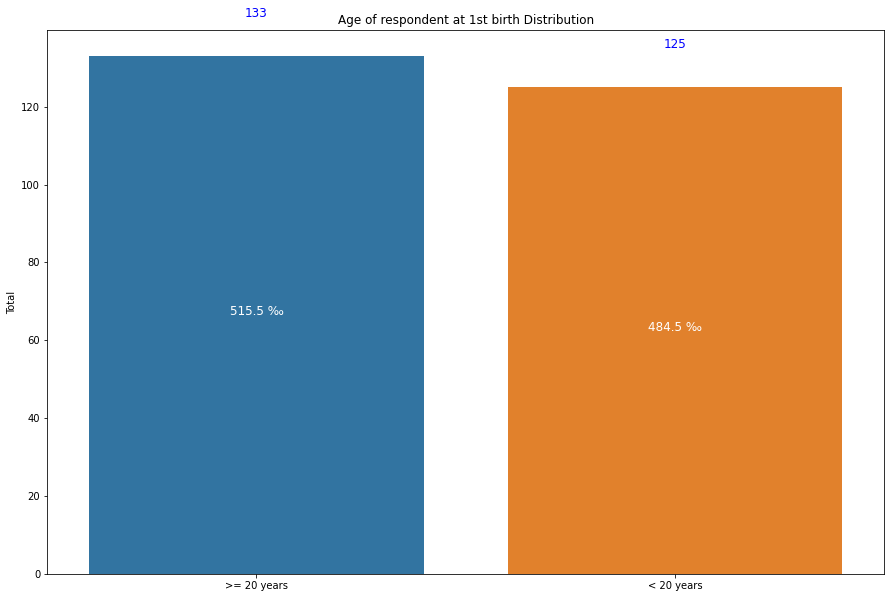

,Total,Per thousand
>= 20 years,133,515.503876
< 20 years,125,484.496124


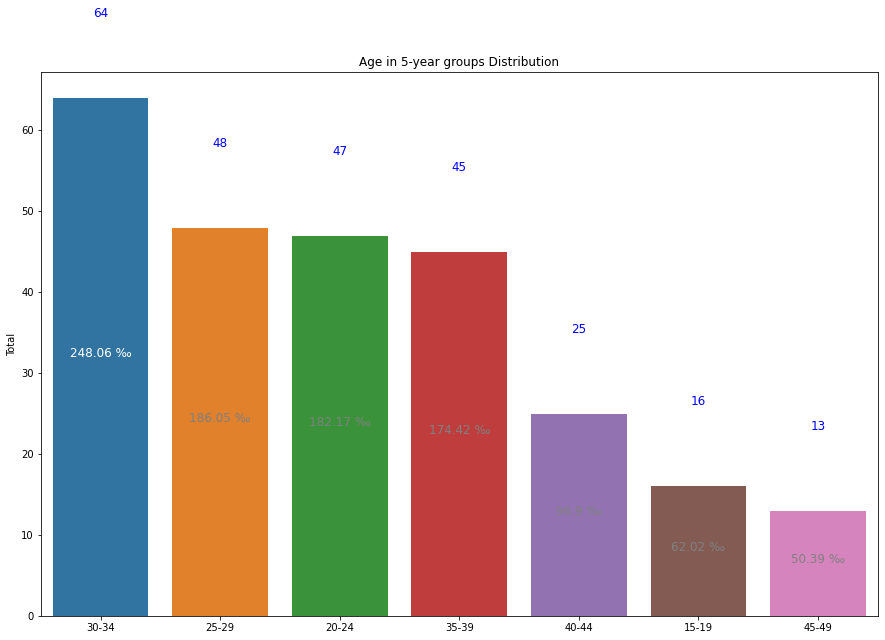

,Total,Per thousand
30-34,64,248.062016
25-29,48,186.046512
20-24,47,182.170543
35-39,45,174.418605
40-44,25,96.899225
15-19,16,62.015504
45-49,13,50.387597


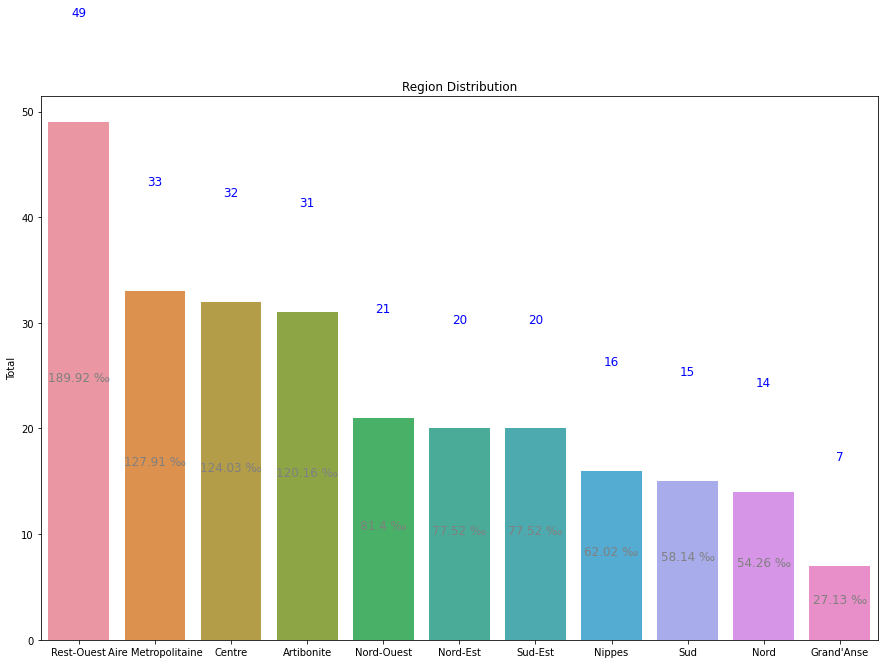

,Total,Per thousand
Rest-Ouest,49,189.922481
Aire Metropolitaine,33,127.906977
Centre,32,124.031008
Artibonite,31,120.155039
Nord-Ouest,21,81.395349
Nord-Est,20,77.519380
Sud-Est,20,77.519380
Nippes,16,62.015504
Sud,15,58.139535
Nord,14,54.263566


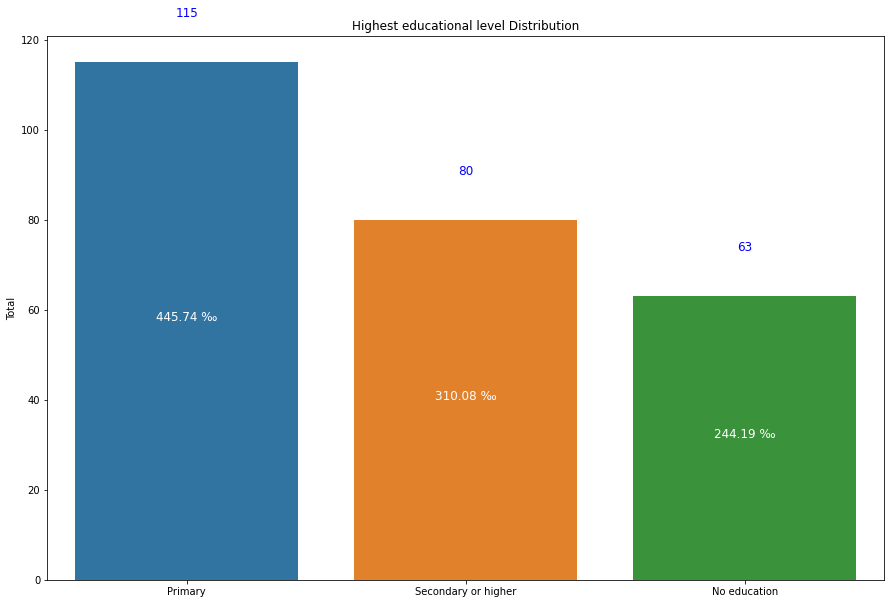

,Total,Per thousand
Primary,115,445.736434
Secondary or higher,80,310.077519
No education,63,244.186047


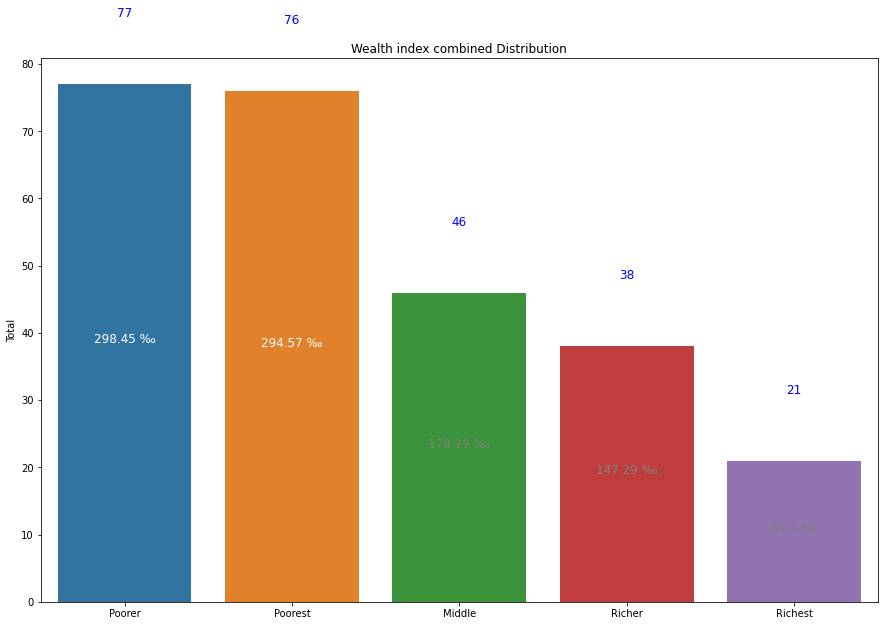

,Total,Per thousand
Poorer,77,298.449612
Poorest,76,294.573643
Middle,46,178.294574
Richer,38,147.286822
Richest,21,81.395349


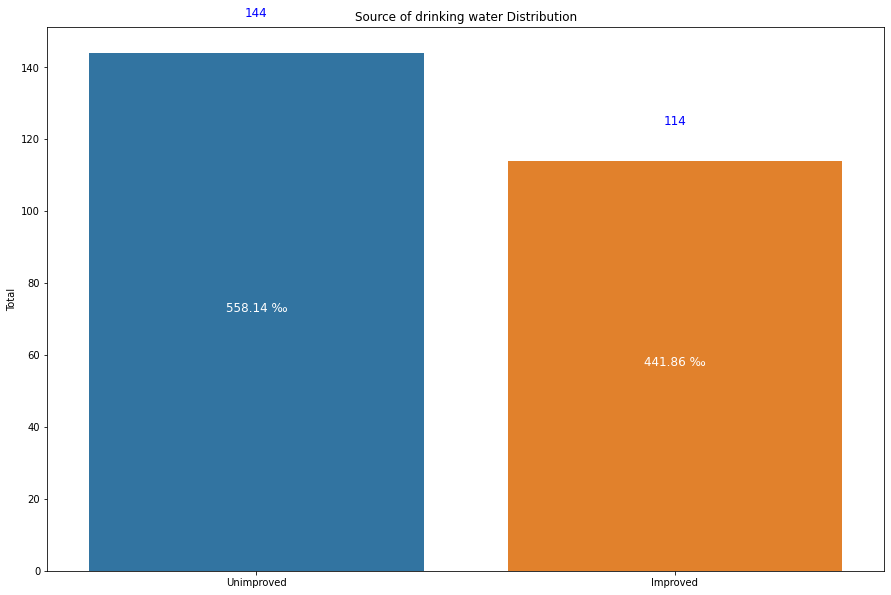

,Total,Per thousand
Unimproved,144,558.139535
Improved,114,441.860465


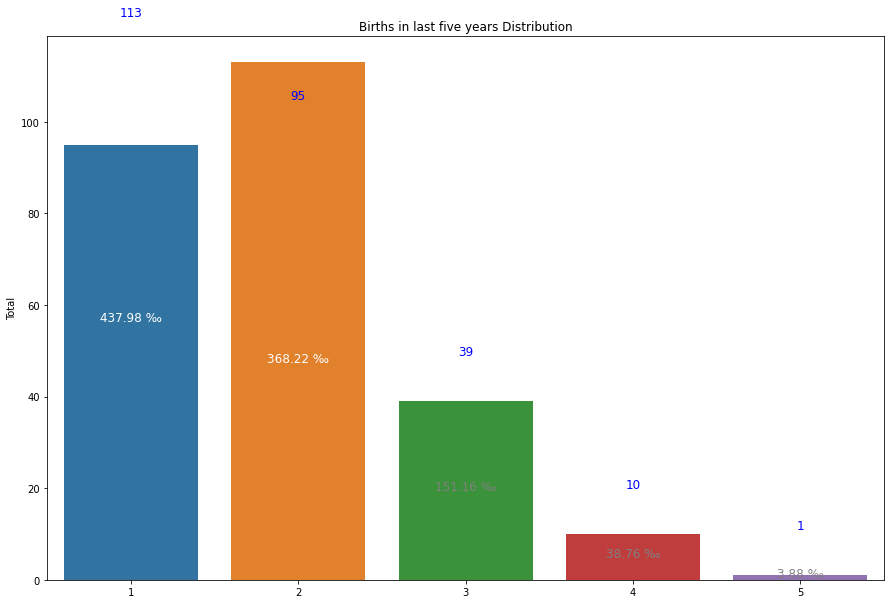

,Total,Per thousand
2,113,437.984496
1,95,368.217054
3,39,151.162791
4,10,38.759690
5,1,3.875969


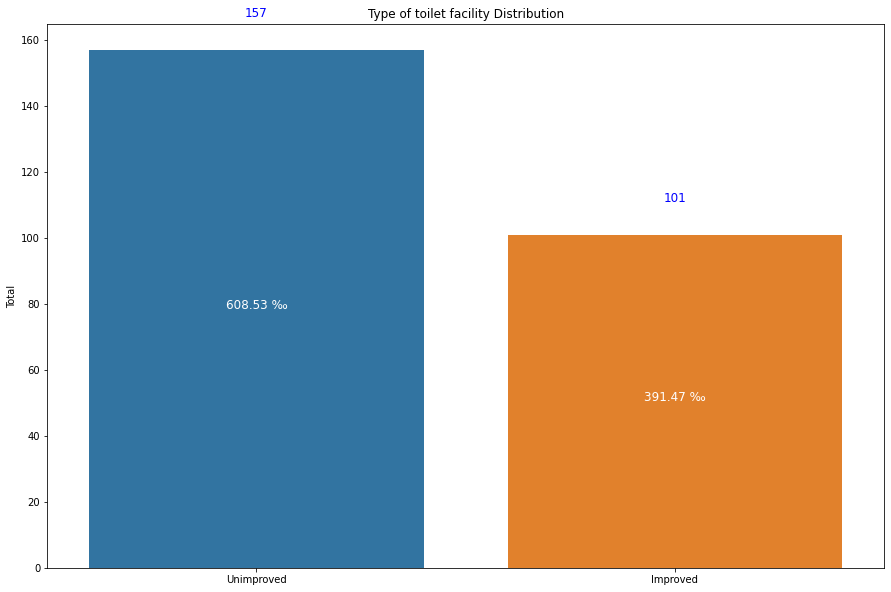

,Total,Per thousand
Unimproved,157,608.527132
Improved,101,391.472868


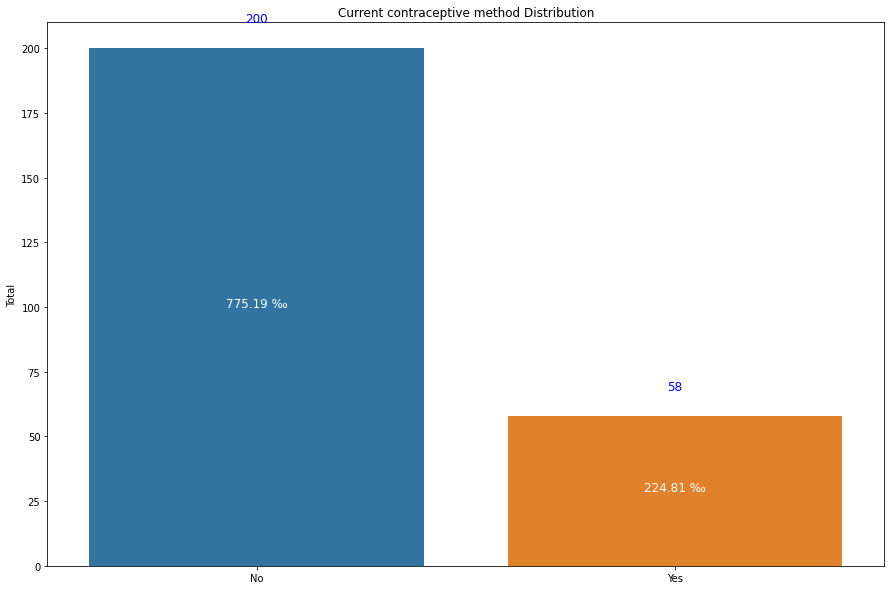

,Total,Per thousand
No,200,775.193798
Yes,58,224.806202


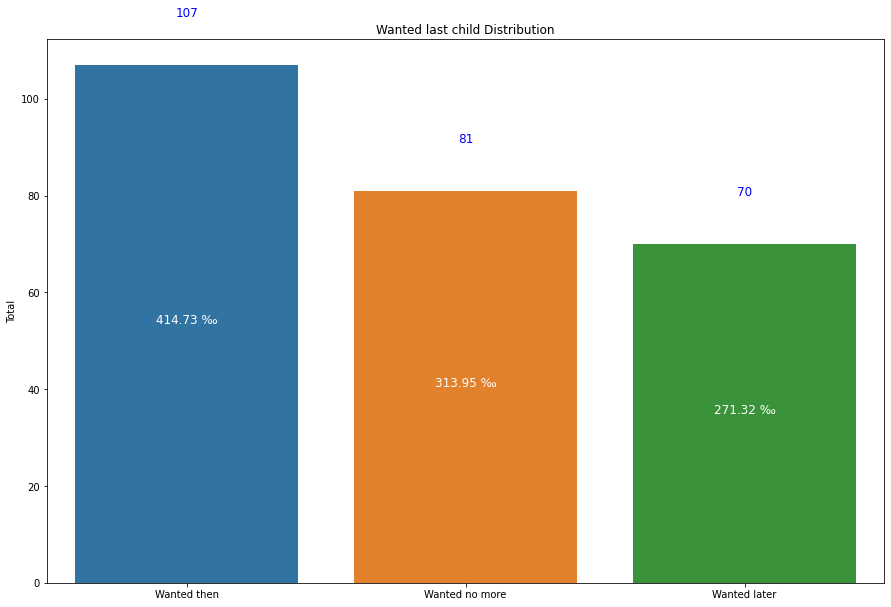

,Total,Per thousand
Wanted then,107,414.728682
Wanted no more,81,313.953488
Wanted later,70,271.317829


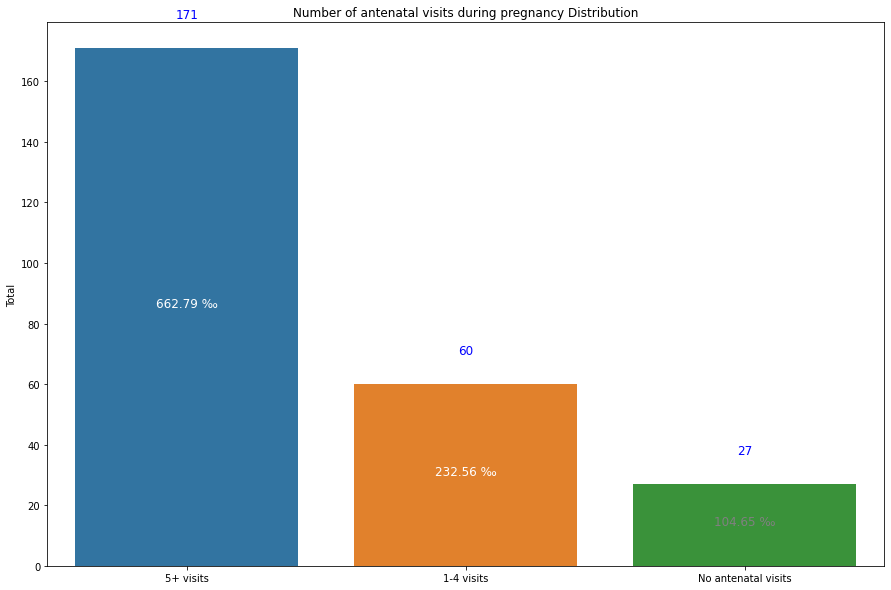

,Total,Per thousand
5+ visits,171,662.790698
1-4 visits,60,232.558140
No antenatal visits,27,104.651163


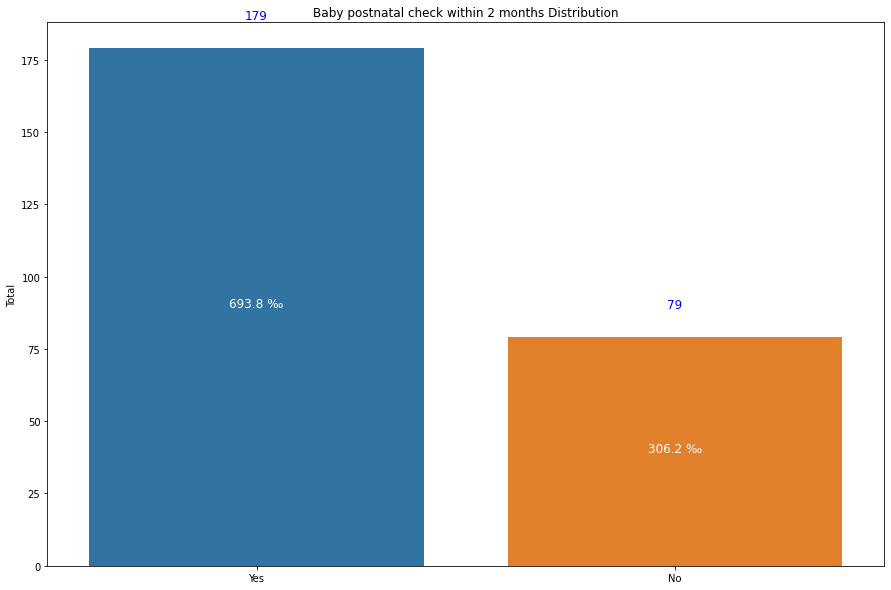

,Total,Per thousand
Yes,179,693.79845
No,79,306.20155


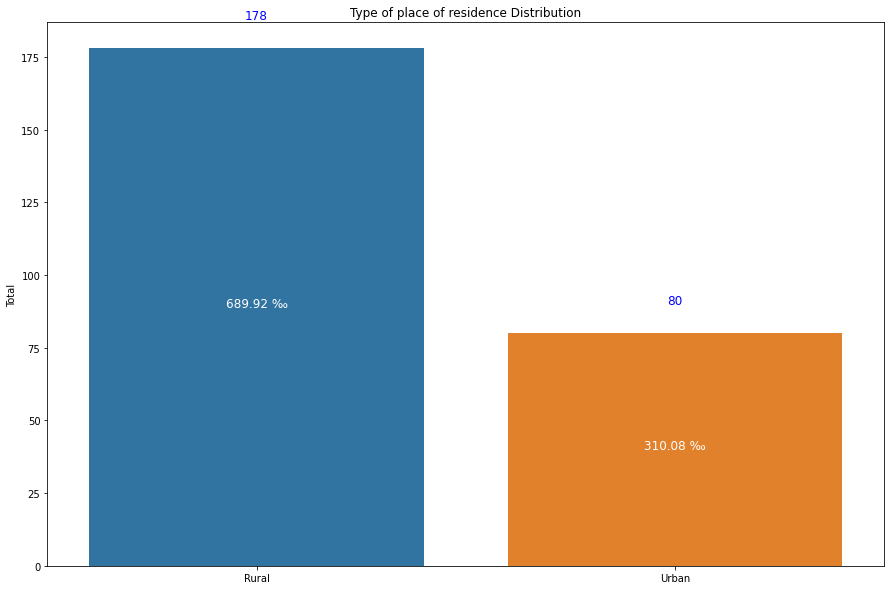

,Total,Per thousand
Rural,178,689.922481
Urban,80,310.077519


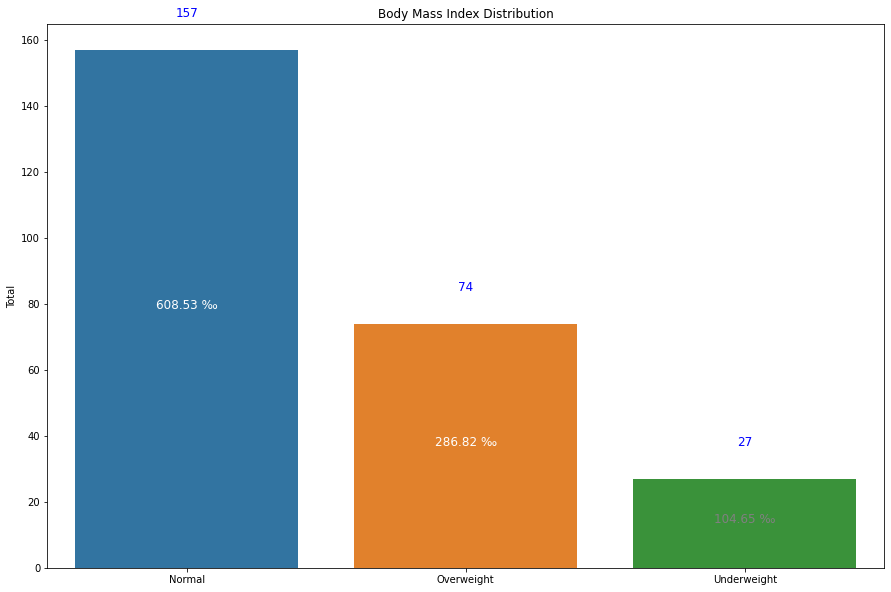

,Total,Per thousand
Normal,157,608.527132
Overweight,74,286.821705
Underweight,27,104.651163


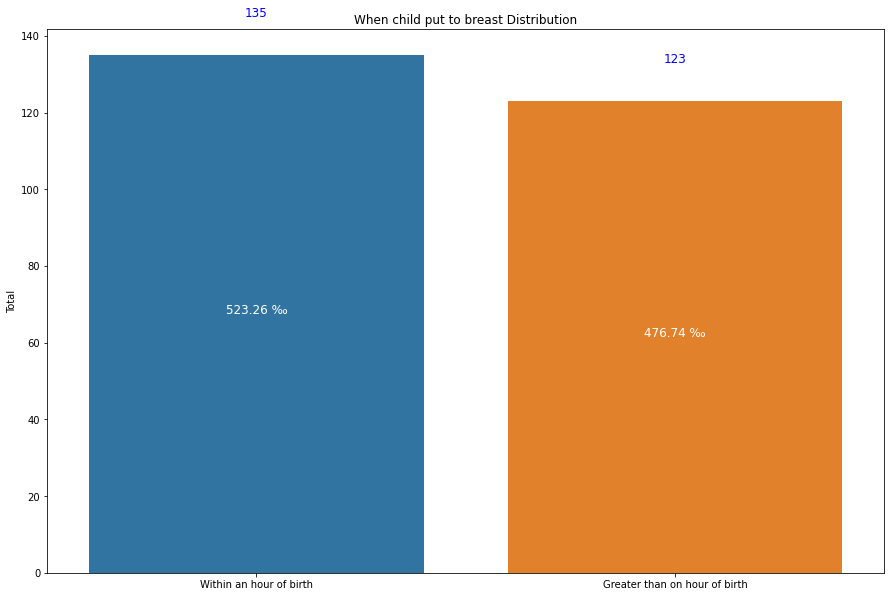

,Total,Per thousand
Within an hour of birth,135,523.255814
Greater than on hour of birth,123,476.744186


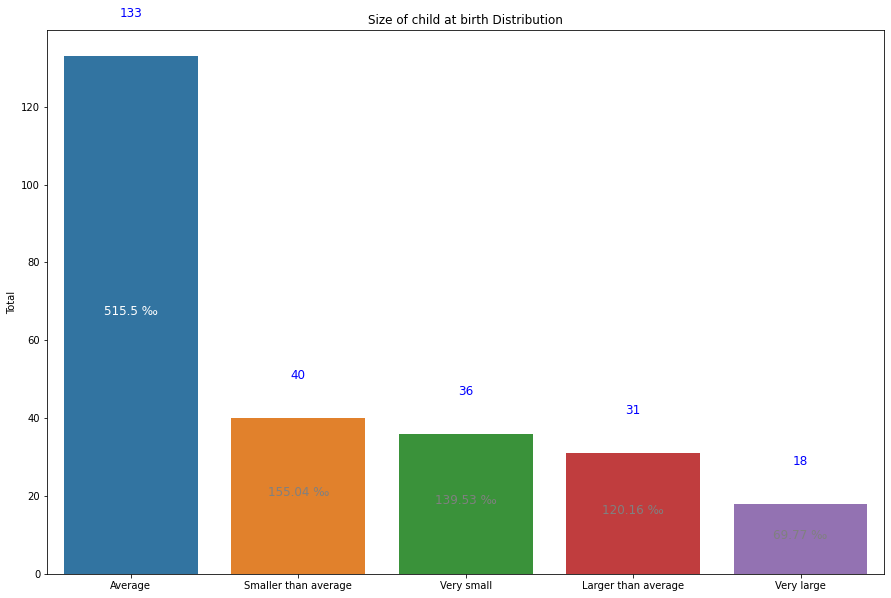

,Total,Per thousand
Average,133,515.503876
Smaller than average,40,155.038760
Very small,36,139.534884
Larger than average,31,120.155039
Very large,18,69.767442


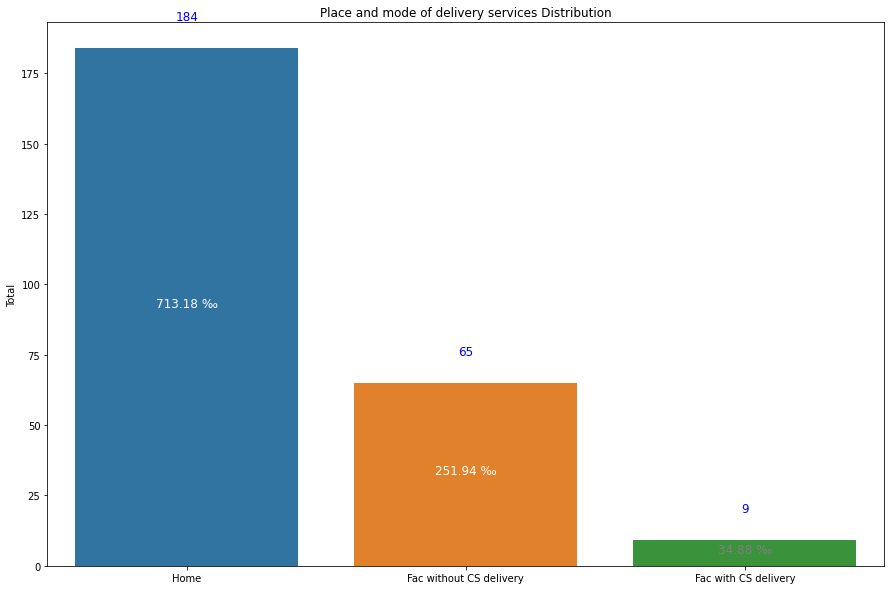

,Total,Per thousand
Home,184,713.178295
Fac without CS delivery,65,251.937984
Fac with CS delivery,9,34.883721


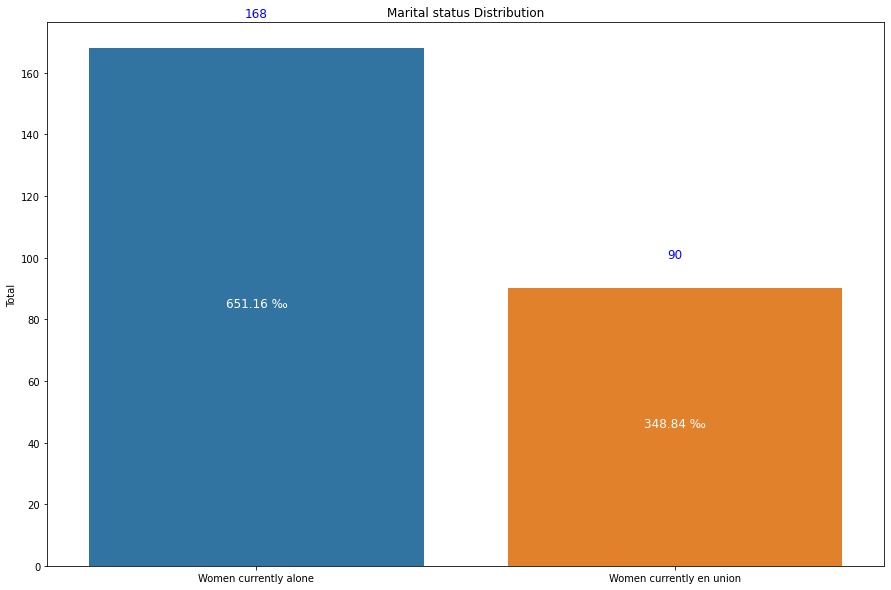

,Total,Per thousand
Women currently alone,168,651.162791
Women currently en union,90,348.837209


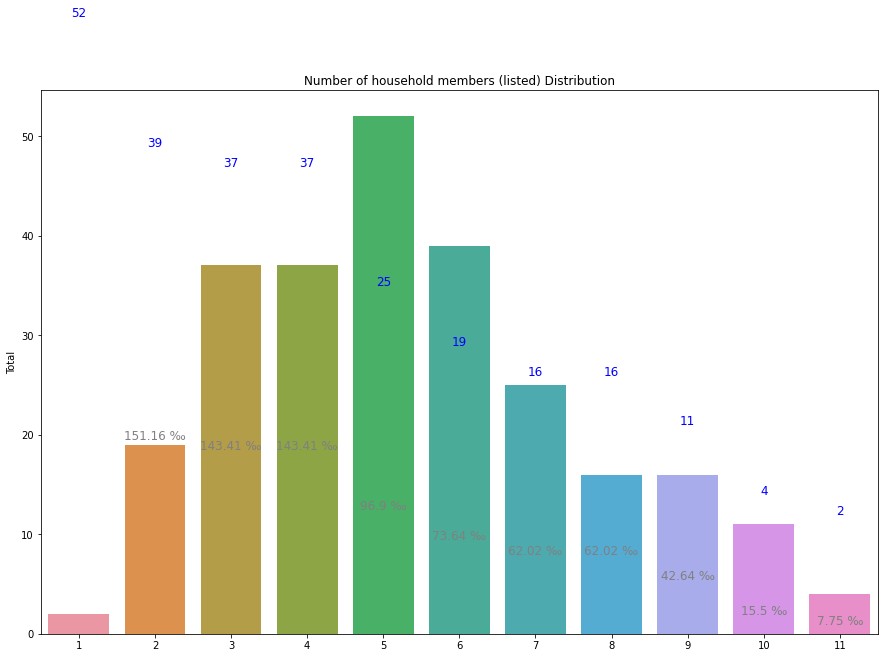

,Total,Per thousand
5,52,201.550388
6,39,151.162791
4,37,143.410853
3,37,143.410853
7,25,96.899225
2,19,73.643411
8,16,62.015504
9,16,62.015504
10,11,42.635659
11,4,15.503876


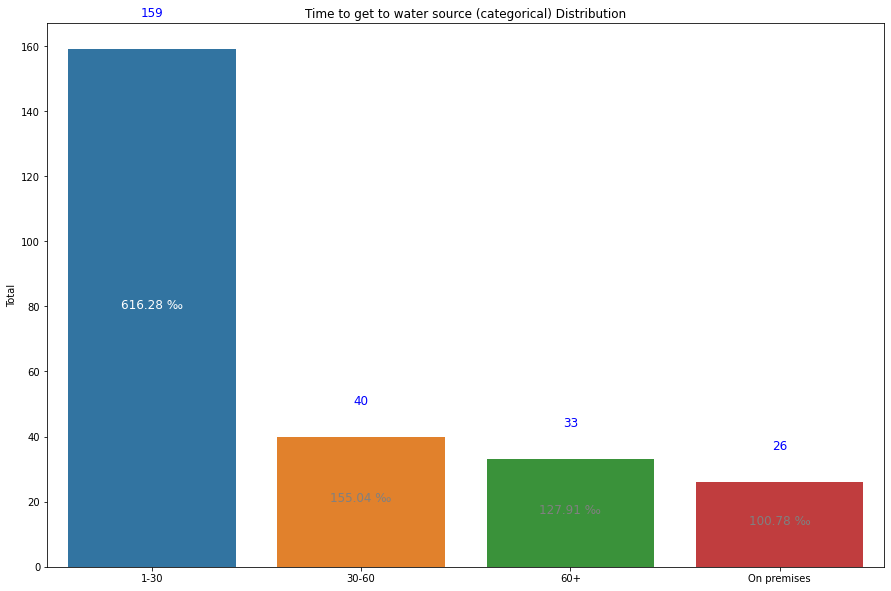

,Total,Per thousand
1-30,159,616.279070
30-60,40,155.038760
60+,33,127.906977
On premises,26,100.775194


In [181]:
for cat_col in cat_cols:
  outcome = dead_category(data = death_children, col=cat_col, abs_value ="Total",rel_value ="Per thousand",show_plot=True,title=f"{cat_col} Distribution")
  display(outcome)

In [182]:
# We create a function to generate Pivot table, Chi-square tests & Bivariate BarPlot

categorical_var = ""
  
def my_chisqure(data=death_children,columns=None,significance_level=0.05,heatmap=False):

  result1  = pd.pivot_table(data=data,index=columns[0],columns=columns[1],values = "Time to get to water source",aggfunc="count",fill_value=0)
  result2  = pd.pivot_table(data=data,index=columns[0],columns=columns[1],values = "Time to get to water source",aggfunc="count",fill_value=0,margins = True)
  display(result2)
  
  

  stat, p, dof,s= chi2_contingency(result1) 
  print("p value: " + str(p)) 
  if p <= significance_level: 
    print('We reject NULL HYPOTHESIS') 
    print(f"The two categorical variables are not independent—that is, {categorical_var} is not independent Whether the type of mortality.")
  else: 
    print('We cannot reject NULL HYPOTHESIS') 
    print(f"The two categorical variables are independent—that is, {categorical_var} is independent Whether type of mortality.")

  # Force the aspect ratio of the blocks to be equal using "square" parameter




In [183]:
chiSquareVar = ["Sex of child", "Birth order number", "Preceding birth interval (months)", "Age of respondent at 1st birth", "Age in 5-year groups", "Region", "Highest educational level", "Wealth index combined", "Source of drinking water", "Births in last five years", "Type of toilet facility", "Current contraceptive method", "Wanted last child", "Number of antenatal visits during pregnancy", "Baby postnatal check within 2 months", "Type of place of residence", "Body Mass Index", "When child put to breast", "Size of child at birth", "Place and mode of delivery services", "Marital status", "Number of household members (listed)", "Time to get to water source (categorical)"]


for categorical_var in chiSquareVar:
    my_chisqure(death_children,columns=[f"{categorical_var}", 'Age at death (months, imputed)'],significance_level=0.05,heatmap=False)

"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Sex of child,,,,
Female,14,48,50,112
Male,25,66,55,146
All,39,114,105,258


p value: 0.4205828457468721
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Sex of child is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Birth order number,,,,
1st_or_ 2nd,16,54,35,105
3rd higher,23,60,70,153
All,39,114,105,258


p value: 0.10736097391140877
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Birth order number is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Preceding birth interval (months),,,,
2-4 years,21,76,66,163
< 2 years,9,22,23,54
> 4 years,9,16,16,41
All,39,114,105,258


p value: 0.6303733758669021
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Preceding birth interval (months) is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Age of respondent at 1st birth,,,,
< 20 years,20,55,50,125
>= 20 years,19,59,55,133
All,39,114,105,258


p value: 0.9248833639267342
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Age of respondent at 1st birth is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Age in 5-year groups,,,,
15-19,1,9,6,16
20-24,7,27,13,47
25-29,11,15,22,48
30-34,10,26,28,64
35-39,4,17,24,45
40-44,5,16,4,25
45-49,1,4,8,13
All,39,114,105,258


p value: 0.04067925029455543
We reject NULL HYPOTHESIS
The two categorical variables are not independent—that is, Age in 5-year groups is not independent Whether the type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Region,,,,
Aire Metropolitaine,2,17,14,33
Artibonite,5,11,15,31
Centre,7,10,15,32
Grand'Anse,1,5,1,7
Nippes,2,10,4,16
Nord,5,4,5,14
Nord-Est,0,10,10,20
Nord-Ouest,4,8,9,21
Rest-Ouest,7,18,24,49


p value: 0.054224810856127306
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Region is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Highest educational level,,,,
No education,14,19,30,63
Primary,15,51,49,115
Secondary or higher,10,44,26,80
All,39,114,105,258


p value: 0.04244989522142211
We reject NULL HYPOTHESIS
The two categorical variables are not independent—that is, Highest educational level is not independent Whether the type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Wealth index combined,,,,
Middle,4,26,16,46
Poorer,10,35,32,77
Poorest,17,23,36,76
Richer,6,17,15,38
Richest,2,13,6,21
All,39,114,105,258


p value: 0.11082654665819466
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Wealth index combined is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Source of drinking water,,,,
Improved,20,44,50,114
Unimproved,19,70,55,144
All,39,114,105,258


p value: 0.25381916501552165
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Source of drinking water is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Births in last five years,,,,
1,18,45,32,95
2,19,49,45,113
3,0,15,24,39
4,2,4,4,10
5,0,1,0,1
All,39,114,105,258


p value: 0.07306291446011733
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Births in last five years is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Type of toilet facility,,,,
Improved,13,55,33,101
Unimproved,26,59,72,157
All,39,114,105,258


p value: 0.028144873338021098
We reject NULL HYPOTHESIS
The two categorical variables are not independent—that is, Type of toilet facility is not independent Whether the type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Current contraceptive method,,,,
No,33,91,76,200
Yes,6,23,29,58
All,39,114,105,258


p value: 0.21595822349386157
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Current contraceptive method is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Wanted last child,,,,
Wanted later,10,35,25,70
Wanted no more,13,26,42,81
Wanted then,16,53,38,107
All,39,114,105,258


p value: 0.10753499095407201
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Wanted last child is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Number of antenatal visits during pregnancy,,,,
1-4 visits,10,29,21,60
5+ visits,26,72,73,171
No antenatal visits,3,13,11,27
All,39,114,105,258


p value: 0.8221570253655633
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Number of antenatal visits during pregnancy is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Baby postnatal check within 2 months,,,,
No,7,50,22,79
Yes,32,64,83,179
All,39,114,105,258


p value: 0.00020620695262492535
We reject NULL HYPOTHESIS
The two categorical variables are not independent—that is, Baby postnatal check within 2 months is not independent Whether the type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Type of place of residence,,,,
Rural,32,71,75,178
Urban,7,43,30,80
All,39,114,105,258


p value: 0.05500461392234893
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Type of place of residence is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Body Mass Index,,,,
Normal,25,63,69,157
Overweight,12,35,27,74
Underweight,2,16,9,27
All,39,114,105,258


p value: 0.35284565959302683
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Body Mass Index is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
When child put to breast,,,,
Greater than on hour of birth,11,73,39,123
Within an hour of birth,28,41,66,135
All,39,114,105,258


p value: 1.1046399054929086e-05
We reject NULL HYPOTHESIS
The two categorical variables are not independent—that is, When child put to breast is not independent Whether the type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Size of child at birth,,,,
Average,19,51,63,133
Larger than average,8,12,11,31
Smaller than average,6,23,11,40
Very large,3,7,8,18
Very small,3,21,12,36
All,39,114,105,258


p value: 0.14983792492372308
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Size of child at birth is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Place and mode of delivery services,,,,
Fac with CS delivery,0,8,1,9
Fac without CS delivery,5,35,25,65
Home,34,71,79,184
All,39,114,105,258


p value: 0.0069926681732487474
We reject NULL HYPOTHESIS
The two categorical variables are not independent—that is, Place and mode of delivery services is not independent Whether the type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Marital status,,,,
Women currently alone,27,73,68,168
Women currently en union,12,41,37,90
All,39,114,105,258


p value: 0.8373058059142086
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Marital status is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Number of household members (listed),,,,
1,0,1,1,2
2,2,9,8,19
3,2,12,23,37
4,7,21,9,37
5,7,26,19,52
6,7,15,17,39
7,4,10,11,25
8,4,7,5,16
9,3,5,8,16


p value: 0.4794524017201187
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Number of household members (listed) is independent Whether type of mortality.


"Age at death (months, imputed)",Child mortality,Neonatal mortality,Post-neonatal mortality,All
Time to get to water source (categorical),,,,
1-30,24,68,67,159
30-60,2,21,17,40
60+,6,15,12,33
On premises,7,10,9,26
All,39,114,105,258


p value: 0.347948856872267
We cannot reject NULL HYPOTHESIS
The two categorical variables are independent—that is, Time to get to water source (categorical) is independent Whether type of mortality.


Exporting the 2 dataframe to excel

In [184]:
with pd.ExcelWriter('output.xlsx') as writer:  
    data_selected.to_excel(writer, sheet_name='All_Live_Births')
    death_children.to_excel(writer, sheet_name='Dead_Child')
    timeByRegion.to_excel(writer, sheet_name='Time_by_Region')

### Machine Learning

Most real-world machine learning problems use supervised learning. In supervised
learning, the model will learn from a labeled training dataset. A label is a target variable
that we want to predict. It is an extra piece of information that helps in making decisions or
predictions, for example, which loan application is safe or risky, whether a patient suffers
from a disease or not, house prices, and credit eligibility scores. These labels act as a
supervisor or teacher for the learning process.  A classification problem has a categorical target variable, such as a loan application status as safe or risky, whether a patient suffers from a "disease" or "not disease," or whether a customer is "potential" or "not potential."

Naive Bayes classification


Naive Bayes is a classification method based on the Bayes theorem. Bayes' theorem is
named after its inventor, the statistician Thomas Bayes. It is a fast, accurate, robust, easy-tounderstand, and interpretable technique. It can also work faster on large datasets. Naive
Bayes is effectively deployed in text mining applications such as document classification,
predicting sentiments of customer reviews, and spam filtering.
The naive Bayes classifier is called naive because it assumes class conditional
independence. Class conditional independence means each feature column is independent
of the remaining other features. For example, in the case of determining whether a person
has diabetes or not, it depends upon their eating habits, their exercise routine, the nature of
their profession, and their lifestyle. Even if features are correlated or depend on each other,
naive Bayes will still assume they are independent.  

Decision tree classification


A decision tree is one of the most well-known classification techniques. It can be employed
for both types of supervised learning problems (classification and regression problems). It
is a flowchart-like tree structure and mimics human-level thinking, which makes it easier to
understand and interpret. It also makes you see the logic behind the prediction unlike
black-box algorithms such as SVMs and neural networks.
The decision tree has three basic components: the internal node, the branch, and leaf nodes.
Here, each terminal node represents a feature, the link represents the decision rule or split
rule, and the leaf provides the result of the prediction. The first starting or master node in
the tree is the root node. It partitions the data based on features or attributes values.

KNN classification


KNN is a simple, easy-to-comprehend, and easy-to-implement classification algorithm. It
can also be used for regression problems. KNN can be employed in lots of use cases, such
as item recommendations and classification problems. Specifically, it can suggest movies on
Netflix, articles on Medium, candidates on naukari.com, products on eBay, and videos on
YouTube. In classification, it can be used to classify instances such as, for example, banking
institutes that can classify the loan of risky candidates, or political scientists can classify
potential voters.

SVM classification



SVMs are the most preferred and favorite machine learning algorithms by many data
scientists due to their accuracy with less computation power. They are employed for both
regression and classification problems. They also offer a kernel trick to model non-linear
relationships. SVM has a variety of use cases, such as intrusion detection, text classification,
face detection, and handwriting recognition.
SVM is a discriminative model that generates optimal hyperplanes with a large margin in
n-dimensional space to separate data points. The basic idea is to discover the Maximum
Marginal Hyperplane (MMH) that perfectly separates data into given classes. The
maximum margin means the maximum distance between data points of both classes.

Splitting training and testing sets


Data scientists need to assess the performance of a model, overcome overfitting, and tune
the hyperparameters. All these tasks require some hidden data records that were not used
in the model development phase. Before model development, the data needs to be divided
into some parts, such as train, test, and validation sets. The training dataset is used to build
the model. The test dataset is used to assess the performance of a model that was trained on
the train set. The validation set is used to find the hyperparameters.

Holdout


In this method, the dataset is divided randomly into two parts: a training and testing set.
Generally, this ratio is 2:1, which means 2/3 for training and 1/3 for testing. We can also
split it into different ratios, such as 6:4, 7:3, and 8:2:

Confusion matrix


A confusion matrix is an approach that gives a brief statement of prediction results on a
binary and multi-class classification problem. Let's assume we have to find out whether a
person has diabetes or not. The concept behind the confusion matrix is to find the number
of right and mistaken forecasts, which are further summarized and separated into each
class. It clarifies all the confusion related to the performance of our classification model.


Precision


When the model predicted Yes, how often was it correct? This is the percentage of positive
cases out of the total predicted cases in the dataset. In simple terms, we can understand
precision as "Up to what level our model is right when it says it's right":

Recall


When it is actually Yes, how often did the model predict Yes? This is also known as
sensitivity. This is the percentage of positive cases out of all the total actual cases present in
the dataset:

F-measure



F-measure is considered as one of the better ways to assess the model. In lots of areas of
data science, competition model performance is assessed using F-measure. It is a harmonic
mean of precision and recall. The higher the value of the F1-score, the better the model is
considered. F1-score provides equal weightage to precision and recall, which means it
indicates a balance between both:


ROC curve and AUC


AUC-ROC curve is a tool to measure and assess the performance of classification models.
ROC (Receiver Operating Characteristics) is a pictorial visualization of model
performance. It plots a two-dimensional probability plot between the FP rate (or 1-
specificity) and the TP rate (or sensitivity).

    "Child is alive", 
    "Sex of child", 
    "Birth order number", 
    "Preceding birth interval (months)", 
    "Age of respondent at 1st birth", 
    "Age in 5-year groups", 
    "Region", 
    "Highest educational level", 
    "Wealth index combined", 
    "Source of drinking water", 
    "Time to get to water source", 
    "Births in last five years", 
    "Type of toilet facility", 
    "Current contraceptive method", 
    "Wanted last child", 
    "Number of antenatal visits during pregnancy",
    "Baby postnatal check within 2 months",
    "Type of place of residence", 
    "Body Mass Index", 
    "When child put to breast", 
    "Size of child at birth", 
    "Place and mode of delivery services",
    "Marital status", 
    "Number of household members (listed)", 
    "Time to get to water source (categorical)"]

Dummy variables are categorical independent variables used in regression analysis. It is
also known as a Boolean, indicator, qualitative, categorical, and binary variable. Dummy
variables convert a categorical variable with N distinct values into N–1 dummy variables. It
only takes the 1 and 0 binary values, which are equivalent to existence and nonexistence.



We can remove one column to avoid collinearity using the drop_first=True argument
and drop first the N–1 dummies out of N categorical levels by removing the first level:



In [185]:
# Dummy encoding
data_to_encoded = data_selected[set(category_colomns)]
one_hot_encoded = pd.get_dummies(data_to_encoded, columns = ["Child is alive", "Sex of child", "Birth order number", "Preceding birth interval (months)", "Age of respondent at 1st birth", "Age in 5-year groups", "Region", "Highest educational level", "Wealth index combined", "Source of drinking water", "Type of toilet facility", "Current contraceptive method", "Wanted last child", "Number of antenatal visits during pregnancy", "Baby postnatal check within 2 months", "Type of place of residence", "Body Mass Index", "When child put to breast", "Size of child at birth", "Place and mode of delivery services", "Marital status"])



In [186]:
pd.set_option("display.max_columns", None)

one_hot_encoded.head(10)

,Time to get to water source (categorical),Time to get to water source,Number of household members (listed),Births in last five years,Child is alive_Alive,Child is alive_Dead,Sex of child_Female,Sex of child_Male,Birth order number_1st_or_ 2nd,Birth order number_3rd higher,Preceding birth interval (months)_2-4 years,Preceding birth interval (months)_< 2 years,Preceding birth interval (months)_> 4 years,Age of respondent at 1st birth_< 20 years,Age of respondent at 1st birth_>= 20 years,Age in 5-year groups_15-19,Age in 5-year groups_20-24,Age in 5-year groups_25-29,Age in 5-year groups_30-34,Age in 5-year groups_35-39,Age in 5-year groups_40-44,Age in 5-year groups_45-49,Region_Aire Metropolitaine,Region_Artibonite,Region_Centre,Region_Grand'Anse,Region_Nippes,Region_Nord,Region_Nord-Est,Region_Nord-Ouest,Region_Rest-Ouest,Region_Sud,Region_Sud-Est,Highest educational level_No education,Highest educational level_Primary,Highest educational level_Secondary or higher,Wealth index combined_Middle,Wealth index combined_Poorer,Wealth index combined_Poorest,Wealth index combined_Richer,Wealth index combined_Richest,Source of drinking water_Improved,Source of drinking water_Unimproved,Type of toilet facility_Improved,Type of toilet facility_Unimproved,Current contraceptive method_No,Current contraceptive method_Yes,Wanted last child_Wanted later,Wanted last child_Wanted no more,Wanted last child_Wanted then,Number of antenatal visits during pregnancy_1-4 visits,Number of antenatal visits during pregnancy_5+ visits,Number of antenatal visits during pregnancy_No antenatal visits,Baby postnatal check within 2 months_No,Baby postnatal check within 2 months_Yes,Type of place of residence_Rural,Type of place of residence_Urban,Body Mass Index_Normal,Body Mass Index_Overweight,Body Mass Index_Underweight,When child put to breast_Greater than on hour of birth,When child put to breast_Within an hour of birth,Size of child at birth_Average,Size of child at birth_Larger than average,Size of child at birth_Smaller than average,Size of child at birth_Very large,Size of child at birth_Very small,Place and mode of delivery services_Fac with CS delivery,Place and mode of delivery services_Fac without CS delivery,Place and mode of delivery services_Home,Marital status_Women currently alone,Marital status_Women currently en union
1,1-30,5,7,2,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1
2,1-30,5,7,2,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1
3,1-30,25,4,3,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0
4,1-30,25,4,3,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0
5,1-30,25,4,3,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0
7,On premises,1,5,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1
8,On premises,1,6,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
10,On premises,1,5,2,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0
11,On premises,1,5,2,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0
12,On premises,1,7,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0


In [187]:
one_hot_encoded.shape

(4253, 72)

In [188]:
# Drop features that do not seem to add any value to our model

one_hot_encoded = one_hot_encoded.drop(["Time to get to water source (categorical)", "Child is alive_Alive", "Sex of child_Female", "Birth order number_3rd higher", "Preceding birth interval (months)_< 2 years", "Age of respondent at 1st birth_< 20 years", "Age in 5-year groups_45-49", "Region_Nippes", "Highest educational level_No education", "Wealth index combined_Richest", "Source of drinking water_Improved", "Type of toilet facility_Improved", "Current contraceptive method_Yes", "Wanted last child_Wanted no more", "Number of antenatal visits during pregnancy_No antenatal visits", "Baby postnatal check within 2 months_No", "Type of place of residence_Urban", "Body Mass Index_Underweight", "When child put to breast_Greater than on hour of birth", "Place and mode of delivery services_Fac with CS delivery", "Marital status_Women currently en union"], axis = 1)

In [189]:
one_hot_encoded.shape

(4253, 51)

In [190]:
pd.set_option("display.max_columns", None)

one_hot_encoded.head(10)

,Time to get to water source,Number of household members (listed),Births in last five years,Child is alive_Dead,Sex of child_Male,Birth order number_1st_or_ 2nd,Preceding birth interval (months)_2-4 years,Preceding birth interval (months)_> 4 years,Age of respondent at 1st birth_>= 20 years,Age in 5-year groups_15-19,Age in 5-year groups_20-24,Age in 5-year groups_25-29,Age in 5-year groups_30-34,Age in 5-year groups_35-39,Age in 5-year groups_40-44,Region_Aire Metropolitaine,Region_Artibonite,Region_Centre,Region_Grand'Anse,Region_Nord,Region_Nord-Est,Region_Nord-Ouest,Region_Rest-Ouest,Region_Sud,Region_Sud-Est,Highest educational level_Primary,Highest educational level_Secondary or higher,Wealth index combined_Middle,Wealth index combined_Poorer,Wealth index combined_Poorest,Wealth index combined_Richer,Source of drinking water_Unimproved,Type of toilet facility_Unimproved,Current contraceptive method_No,Wanted last child_Wanted later,Wanted last child_Wanted then,Number of antenatal visits during pregnancy_1-4 visits,Number of antenatal visits during pregnancy_5+ visits,Baby postnatal check within 2 months_Yes,Type of place of residence_Rural,Body Mass Index_Normal,Body Mass Index_Overweight,When child put to breast_Within an hour of birth,Size of child at birth_Average,Size of child at birth_Larger than average,Size of child at birth_Smaller than average,Size of child at birth_Very large,Size of child at birth_Very small,Place and mode of delivery services_Fac without CS delivery,Place and mode of delivery services_Home,Marital status_Women currently alone
1,5,7,2,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0
2,5,7,2,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0
3,25,4,3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,1,1
4,25,4,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,1,1
5,25,4,3,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,1,0,0,1,1
7,1,5,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0
8,1,6,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,0
10,1,5,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1,1,0,1,1,0,0,0,0,1,0,1
11,1,5,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,1,1,0,1,1,0,0,0,0,1,0,1
12,1,7,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,1


Supervised Learning -
Classification Techniques

In [191]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  

  
# the independent variables set
X = one_hot_encoded[['Number of household members (listed)', 'Time to get to water source','Births in last five years', 'Sex of child_Male','Birth order number_1st_or_ 2nd','Preceding birth interval (months)_2-4 years','Preceding birth interval (months)_> 4 years','Age of respondent at 1st birth_>= 20 years','Age in 5-year groups_15-19', 'Age in 5-year groups_20-24','Age in 5-year groups_25-29', 'Age in 5-year groups_30-34','Age in 5-year groups_35-39', 'Age in 5-year groups_40-44','Region_Aire Metropolitaine', 'Region_Artibonite', 'Region_Centre',"Region_Grand'Anse", 'Region_Nord', 'Region_Nord-Est','Region_Nord-Ouest', 'Region_Rest-Ouest', 'Region_Sud','Region_Sud-Est', 'Highest educational level_Primary','Highest educational level_Secondary or higher','Wealth index combined_Middle', 'Wealth index combined_Poorer','Wealth index combined_Poorest', 'Wealth index combined_Richer','Source of drinking water_Unimproved','Type of toilet facility_Unimproved', 'Current contraceptive method_No','Wanted last child_Wanted later', 'Wanted last child_Wanted then','Number of antenatal visits during pregnancy_1-4 visits','Number of antenatal visits during pregnancy_5+ visits','Baby postnatal check within 2 months_Yes','Type of place of residence_Rural', 'Body Mass Index_Normal','Body Mass Index_Overweight','When child put to breast_Within an hour of birth','Size of child at birth_Average','Size of child at birth_Larger than average','Size of child at birth_Smaller than average','Size of child at birth_Very large','Size of child at birth_Very small','Place and mode of delivery services_Fac without CS delivery','Place and mode of delivery services_Home','Marital status_Women currently alone']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
features_selected =list(vif_data[vif_data.VIF <=4]['feature'])
features_selected
X = X[features_selected]
y = one_hot_encoded['Child is alive_Dead']

In [192]:
from imblearn.over_sampling import SMOTE

In [193]:
# define oversample strategy
oversample = SMOTE(sampling_strategy=0.3)

In [194]:
X_over, y_over = oversample.fit_resample(X, y)

In [195]:
X_train,X_test,y_train,y_test = train_test_split(X_over,y_over,test_size =0.5,random_state=49)

In [196]:
lr.fit(X_train,y_train)

NameError: name 'lr' is not defined

In [197]:
lr.score(X_test,y_test)

NameError: name 'lr' is not defined

In [198]:
y_pred = lr.predict(X_test)

NameError: name 'lr' is not defined

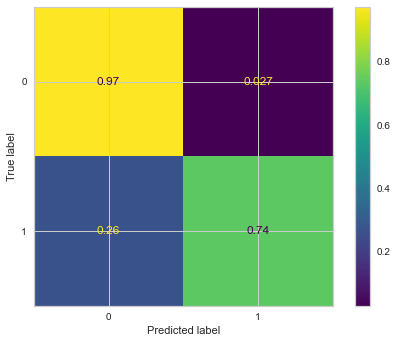

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr,X_test,y_test,normalize="true")

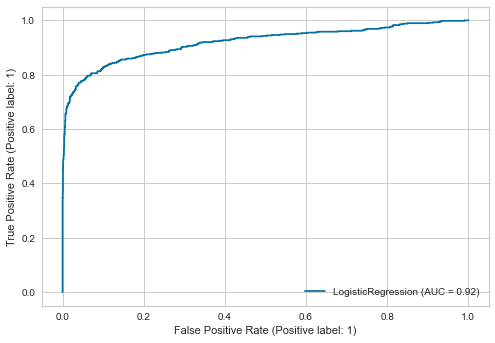

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(lr,X_test,y_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

C:\Users\Yvel Marcelin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Yvel Marcelin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


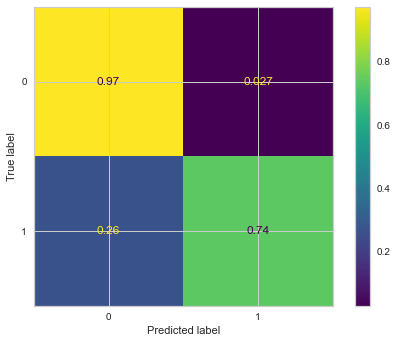

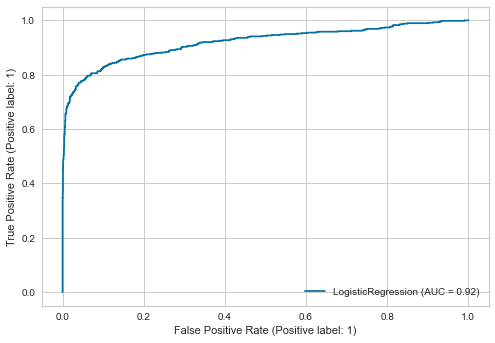

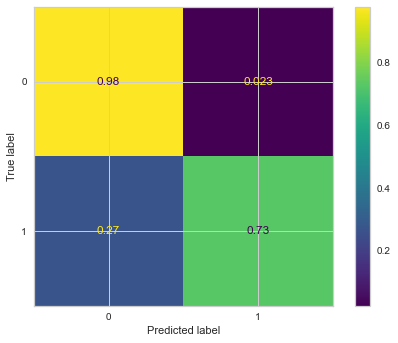

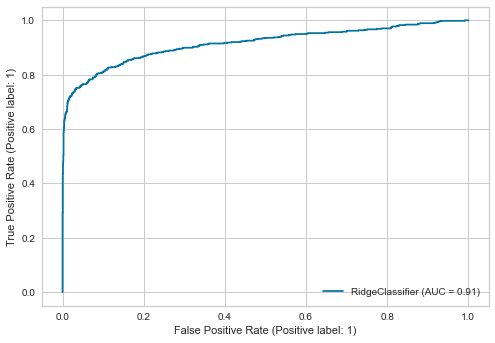

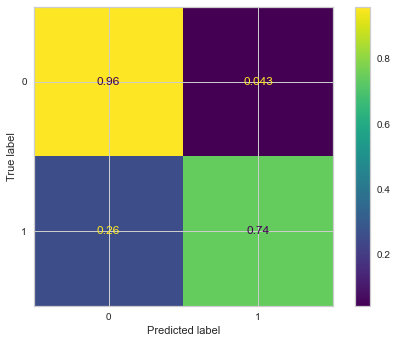

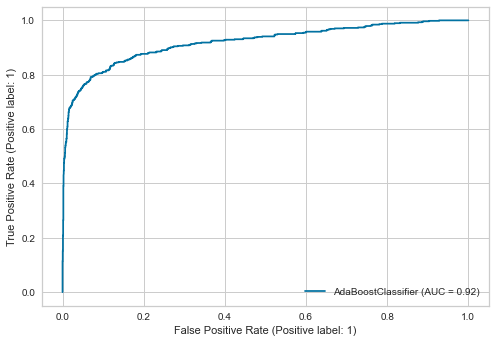

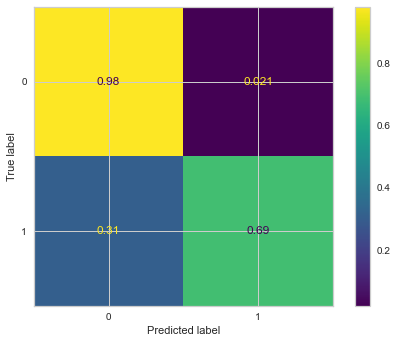

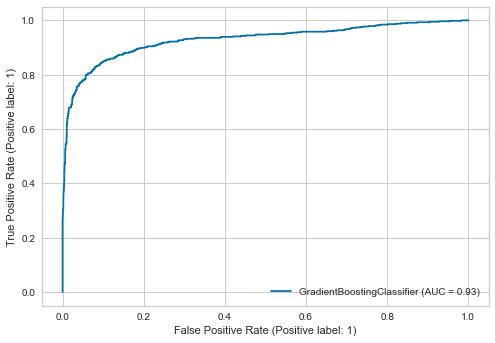

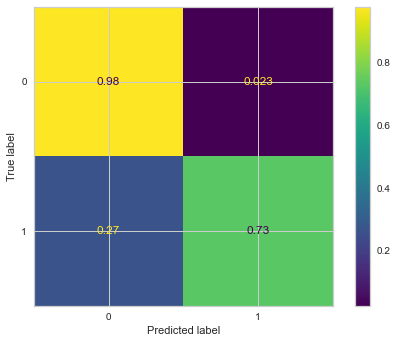

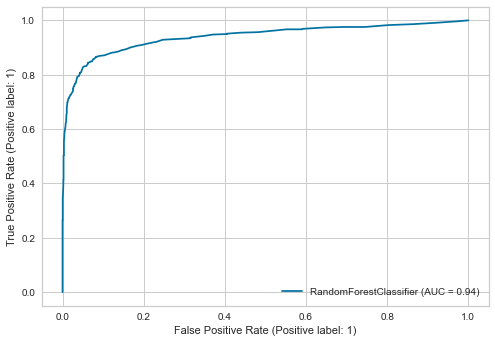

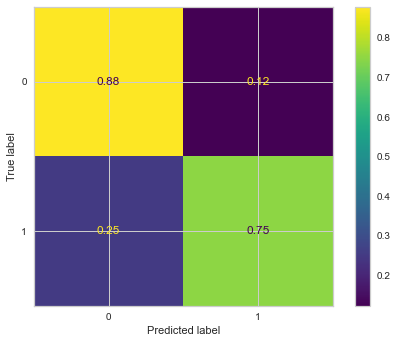

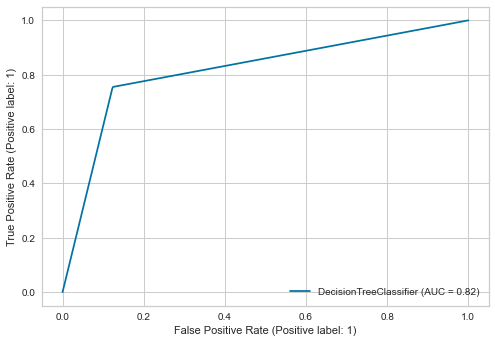

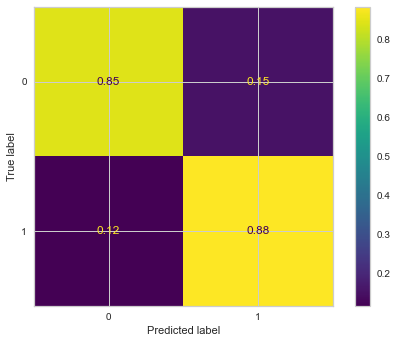

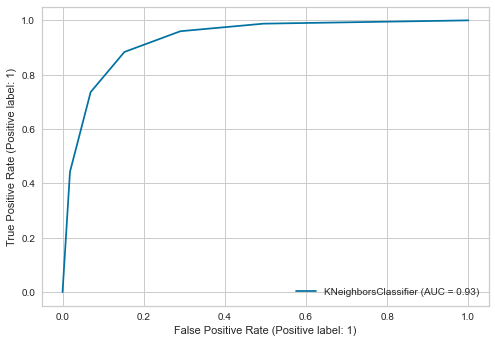

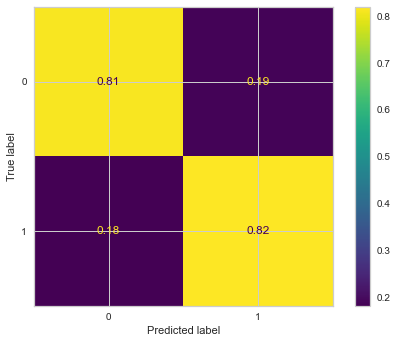

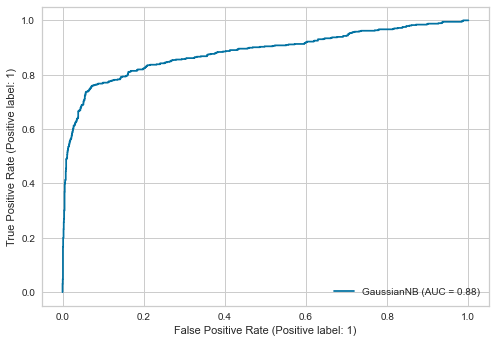

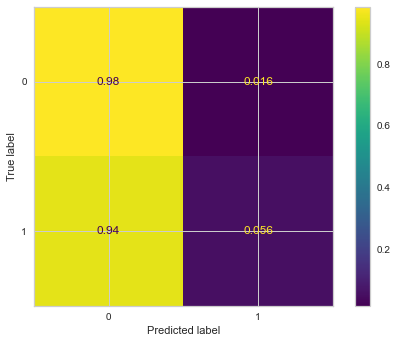

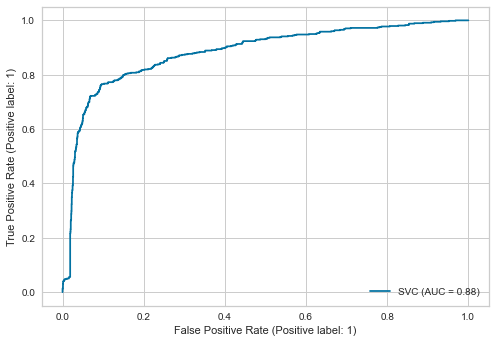

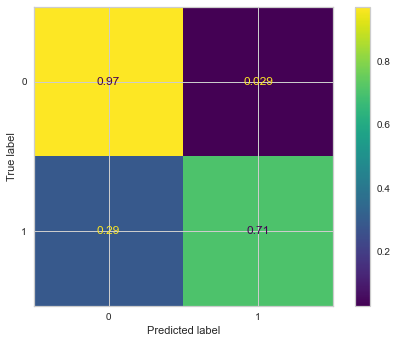

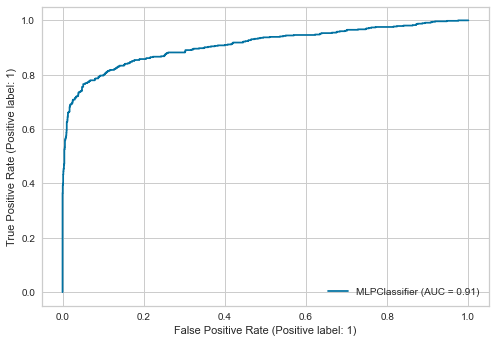

In [ ]:
import time 
#from yellowbrick.classifier import ROCAUC

times_list = []
scores = []
model_names = ["LogisticRegression","RidgeClassifier","AdaBoostClassifier","GradientBoostingClassifier","RandomForestClassifier","DecisionTreeClassifier","KNeighborsClassifier", "GaussianNB", "SVC", "MLPClassifier"]
models = [LogisticRegression(),RidgeClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier(), GaussianNB(), SVC(), MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)]
for model,name in  zip(models,model_names):
  start = time.time()
  model.fit(X_train,y_train)
  end = time.time()
  times_list.append(end-start)
  scores.append( model.score(X_test,y_test))
  plot_confusion_matrix(model,X_test,y_test,normalize="true")
  plot_roc_curve(model,X_test,y_test)
 


   #msles.append(mean_squared_log_error(y_test,y_pred))

df = pd.DataFrame(dict(names=model_names,scores=scores,times=times_list))

In [ ]:
df

,names,scores,times
0,LogisticRegression,0.920678,0.096310
1,RidgeClassifier,0.921833,0.079344
2,AdaBoostClassifier,0.909511,0.157648
3,GradientBoostingClassifier,0.914132,0.330420
4,RandomForestClassifier,0.922988,0.265603
5,DecisionTreeClassifier,0.849057,0.014959
6,KNeighborsClassifier,0.855603,0.000000
7,GaussianNB,0.813631,0.004987
8,SVC,0.778206,0.210782
9,MLPClassifier,0.912591,0.349440


In [ ]:
with pd.ExcelWriter('output.xlsx') as writer:  
    df.to_excel(writer, sheet_name='Accuracies')
    

In [ ]:
for model,name in zip(models[:],model_names[:]):
    y_pred = model.predict(X_test)
    print(name)
    print(classification_report(y_test,y_pred))

LogisticRegression
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2021
           1       0.89      0.74      0.80       576

    accuracy                           0.92      2597
   macro avg       0.91      0.85      0.88      2597
weighted avg       0.92      0.92      0.92      2597

RidgeClassifier
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2021
           1       0.90      0.73      0.81       576

    accuracy                           0.92      2597
   macro avg       0.91      0.85      0.88      2597
weighted avg       0.92      0.92      0.92      2597

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2021
           1       0.83      0.74      0.78       576

    accuracy                           0.91      2597
   macro avg       0.88      0.85      0.86      2597
weighted avg       0